# 🧠 AI-Based Migraine Symptom Classifier for Early Detection and Triage

This notebook develops and interprets a machine learning model to classify migraine subtypes from patient-reported symptoms.  
The goal is to support **early detection and triage** by providing physicians with an AI assistant that predicts the migraine type and explains the key symptoms driving each decision.

**Dataset:** Public Kaggle dataset by Gözde Kızılkaya (400 records, CSV).  
**Target classes:** Migraine without aura, Migraine with aura, Chronic migraine, Hemiplegic migraine, Retinal migraine.  
**Features:** Demographics (Age), pain characteristics (Duration, Frequency, Intensity, Location, Character), and binary neurological symptoms (e.g., Nausea, Photophobia, Visual, Sensory, Motor).

---

## 🔄 Workflow
1. **Data Exploration (EDA):** Inspect distributions, class imbalance, and symptom–type relationships.  
2. **Preprocessing:** Encode categorical features, scale numeric variables, handle imbalance with SMOTE.  
3. **Modeling:** Train Logistic Regression, Random Forest, and XGBoost; tune hyperparameters.  
4. **Evaluation:** Compare models using accuracy, weighted F1, and confusion matrices.  
5. **Interpretability:** Use SHAP for global, class-specific, and local explanations.  
6. **Deployment Notes:** Save best pipeline and outline Streamlit + Gemini API integration.


##### **Imports**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, ConfusionMatrixDisplay

from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline

 
import joblib
import shap


# Exploratory Data Analysis (EDA) 

## Data Loading & Initial Overview

In [2]:
# 1. Loading the data
# ------------------------------------------------------------------------------
data = pd.read_csv('migraine_symptom_classification.csv')
df = data.copy()

display(df.head(3))
print("Shape:", df.shape)
print('-------------------------------')
print("Null Values:", df.isnull().sum())
print('-------------------------------')
df.info()

,Age,Duration,Frequency,Location,Character,Intensity,Nausea,Vomit,Phonophobia,Photophobia,...,Vertigo,Tinnitus,Hypoacusis,Diplopia,Defect,Ataxia,Conscience,Paresthesia,DPF,Type
0,30,1,5,1,1,2,1,0,1,1,...,0,0,0,0,0,0,0,0,0,Typical aura with migraine
1,50,3,5,1,1,3,1,1,1,1,...,1,0,0,0,0,0,0,0,0,Typical aura with migraine
2,53,2,1,1,1,2,1,1,1,1,...,0,0,0,0,0,0,0,0,0,Typical aura with migraine


Shape: (400, 24)
-------------------------------
Null Values: Age            0
Duration       0
Frequency      0
Location       0
Character      0
Intensity      0
Nausea         0
Vomit          0
Phonophobia    0
Photophobia    0
Visual         0
Sensory        0
Dysphasia      0
Dysarthria     0
Vertigo        0
Tinnitus       0
Hypoacusis     0
Diplopia       0
Defect         0
Ataxia         0
Conscience     0
Paresthesia    0
DPF            0
Type           0
dtype: int64
-------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 24 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Age          400 non-null    int64 
 1   Duration     400 non-null    int64 
 2   Frequency    400 non-null    int64 
 3   Location     400 non-null    int64 
 4   Character    400 non-null    int64 
 5   Intensity    400 non-null    int64 
 6   Nausea       400 non-null    int64 
 7   Vomit 

**Dataset Summary**
- **Cases:** 400 migraine episodes (one row = one patient/episode)  
- **Target:** `Type` (7 migraine classifications)  
- **Features:** 23 predictors, mostly binary/ordinal (symptoms + demographics)  
- **Data quality:**  
  - No missing values   
  - Target is string type → will require encoding 

## Feature Distribution (All Variables)

We examine the distributions of all features to understand their ranges, skewness, and balance.  
This helps identify preprocessing needs such as scaling, binarization, or handling class imbalance.


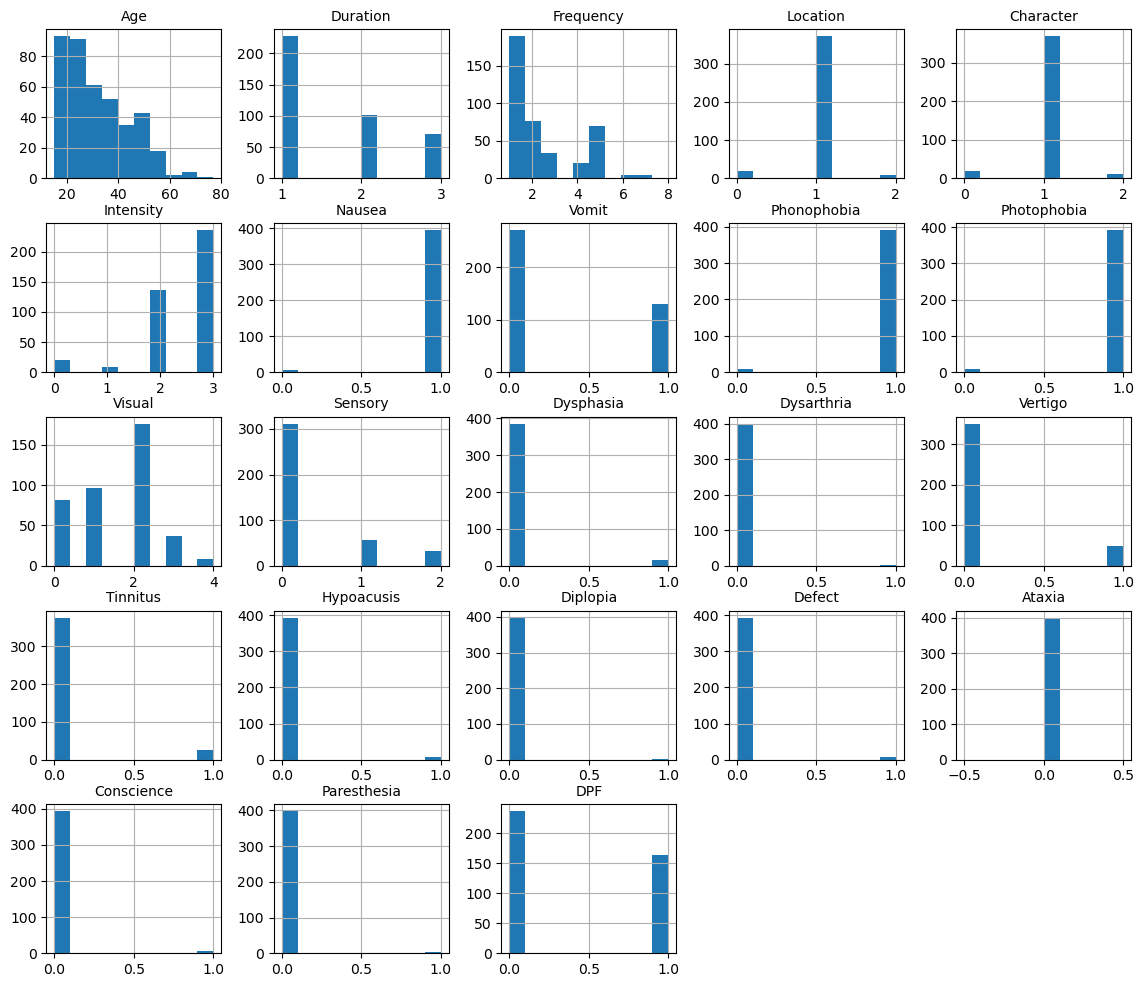

In [3]:
plt.rc('font',size=10)
plt.rc('axes',labelsize=10, titlesize=10)
plt.rc('legend',fontsize=14)
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=10)
df.hist(figsize=(14,12))
plt.show()

**Key Takeaways:**
- ⚖️ Most features are binary (0/1) and show class imbalance (e.g., Visual, Motor, Defect).
- 📈 Continuous fields like `Age`, `Duration`, and `Frequency` display wide variability and skewness—candidates for scaling or transformation.
- 🔢 Ordinal variables (`Location`, `Character`, `Intensity`) are integer-coded— will confirm during encoding.

- 🛠️ These insights guide preprocessing: **binarization** for inconsistent features, **scaling** for continuous ones, **SMOTE** for imbalance, and **normalization** where needed

## 🧠 Symptom Variable Inspection & Cleaning

In [4]:
symptoms= ['Nausea', 'Vomit', 'Phonophobia', 'Photophobia', 'Visual',
            'Sensory', 'Dysphasia', 'Dysarthria', 'Vertigo', 'Tinnitus',
            'Hypoacusis', 'Diplopia', 'Defect', 'Ataxia', 'Conscience',
            'Paresthesia', 'DPF']
df[symptoms].nunique()

Nausea         2
Vomit          2
Phonophobia    2
Photophobia    2
Visual         5
Sensory        3
Dysphasia      2
Dysarthria     2
Vertigo        2
Tinnitus       2
Hypoacusis     2
Diplopia       2
Defect         2
Ataxia         1
Conscience     2
Paresthesia    2
DPF            2
dtype: int64

**Key Takeaways:**
- ✅ `Visual` and `Sensory` **should be binary** despite appearing with more unique values. This suggests improper encoding or data entry inconsistency—will binarize these features to reflect symptom presence accurately.
- ⚠️ `Ataxia` contains a **single value (0)** for all records. Since it offers no variance, it should be dropped from the dataset to avoid adding noise or redundant dimensions.

This correction improves signal clarity and prepares features for balanced resampling and classification.


## Target Class Distribution (Imbalance Check)                                                                             

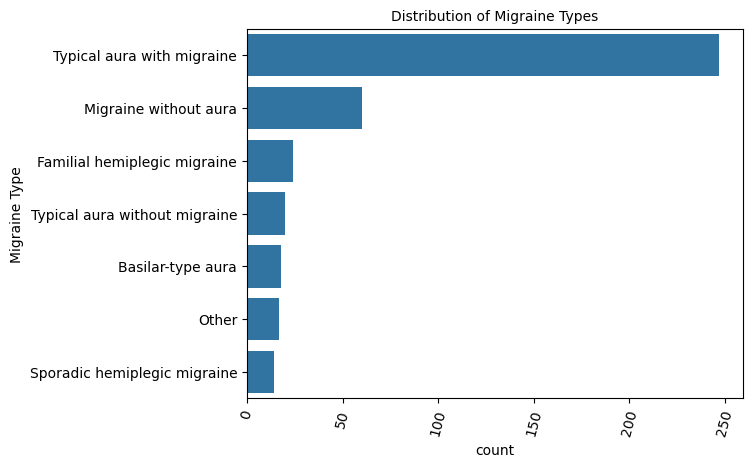

In [5]:
sns.countplot(data=df, y='Type', order=df['Type'].value_counts().index)
plt.title('Distribution of Migraine Types')
plt.xlabel('count')
plt.ylabel('Migraine Type')
plt.tick_params(axis='x',rotation=75)
plt.show()

**Insights:**
- ⚖️ The dataset exhibits **strong class imbalance**.
  - `Typical aura with migraine` and `Migraine without aura` dominate the distribution.
  - Other types like `Familial/Sporadic hemiplegic` and `Basilar-type aura` are significantly underrepresented.
- 🧪 This imbalance could skew model learning—especially for minority classes—requiring **resampling (e.g., SMOTE)**  to ensure fair performance.

## Symptom-Type Relationships                                                                


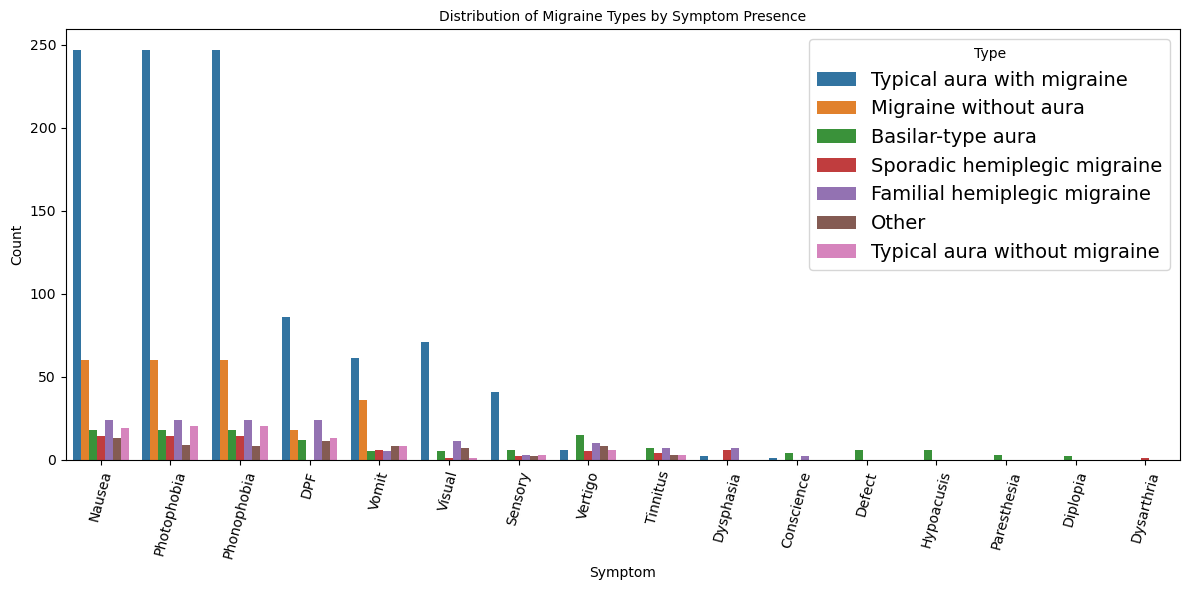

In [6]:
# Melt the DataFrame to long format
df_melted = df.melt(id_vars='Type', value_vars=symptoms,
                    var_name='Symptom', value_name='Presence')

# Filter only rows where symptom is present (== 1)
df_present = df_melted[df_melted['Presence'] == 1]

# Now plot
plt.figure(figsize=(12, 6))
symptom_order = df_present['Symptom'].value_counts().index
sns.countplot(data=df_present, x='Symptom', hue='Type', order=symptom_order)
plt.title('Distribution of Migraine Types by Symptom Presence')
plt.xlabel('Symptom')
plt.ylabel('Count')
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()


**Insights:**
- 🌟 Core symptoms like `Nausea`, `Photophobia`, and `Phonophobia` are widely prevalent in **Typical aura with migraine**, indicating strong class dominance.
- 📊 Less common symptoms such as `Dysarthria`, `Diplopia`, and `Defect` appear sporadically across rare types like **Sporadic Hemiplegic** or **Basilar-type aura**, which may help differentiate these classes during modeling.
- ⚖️ Symptom overlap exists across classes, but specific combinations (e.g., `Visual` + `DPF`) may act as predictive signals for aura-related migraines.

### Heatmap of Symptom Prevalence

This heatmap visualizes the mean presence of each symptom across migraine classes—providing an intuitive view of clinical patterns.

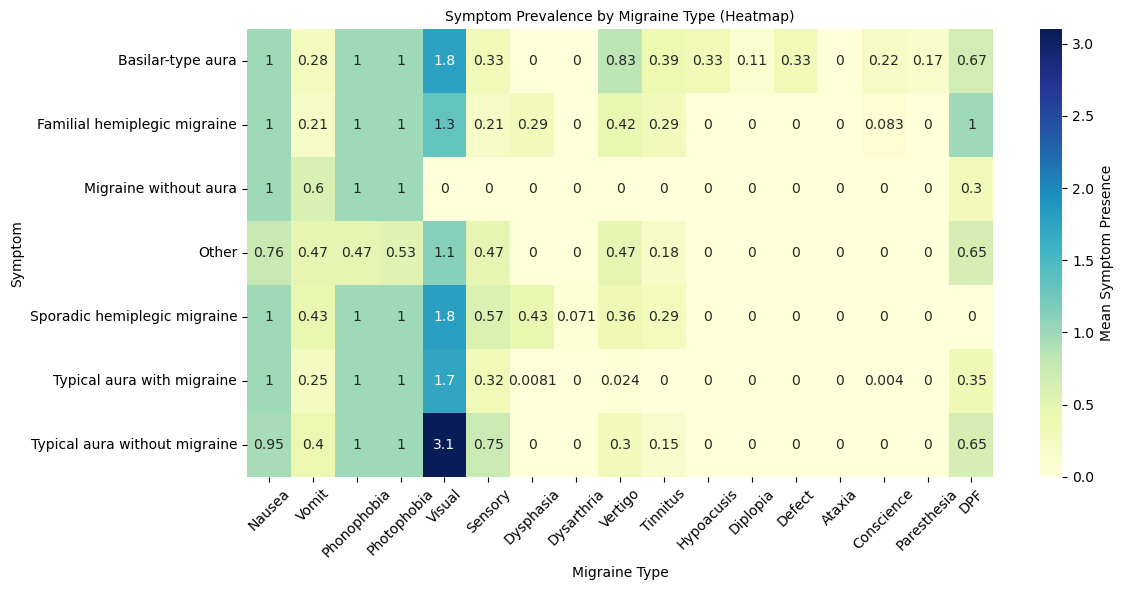

In [7]:
# Mean symptom presence per migraine type
symptom_mean_by_type = df.groupby('Type')[symptoms].mean()

plt.figure(figsize=(12, 6))
sns.heatmap(symptom_mean_by_type, annot=True, cmap='YlGnBu', cbar_kws={'label': 'Mean Symptom Presence'})
plt.title("Symptom Prevalence by Migraine Type (Heatmap)")
plt.xlabel("Migraine Type")
plt.ylabel("Symptom")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Insights:**
- ✅ Symptoms like `Photophobia`, `Phonophobia`, and `Nausea` are commonly present in aura-related migraines, indicating strong predictive signal.
- 🧠 Rarer features such as `Diplopia`, `Defect`, and `Dysarthria` are elevated in hemiplegic and basilar types—valuable for class differentiation.
- 🔎 `DPF` and `Visual` show strong class-specific associations, reinforcing their importance in classification tasks.
- 🚫 `Ataxia` consistently shows zero presence across all migraine types, signaling **no variance**. This feature will be **dropped in upcoming preprocessing** to reduce noise and dimensionality.

## Numeric Feature Distributions by Type
### Age by Type

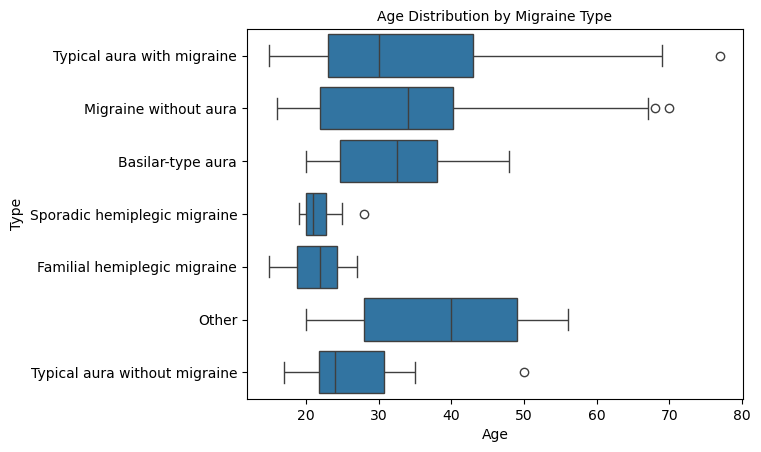

In [8]:
sns.boxplot(data=df, x='Age', y='Type')
plt.title("Age Distribution by Migraine Type")
plt.show()

**Summary:**  
- Younger patients are more represented in `hemiplegic` types.  
- Age distribution overlaps across most other migraine subtypes, limiting its discriminative power.  


### Pain Duration by Type

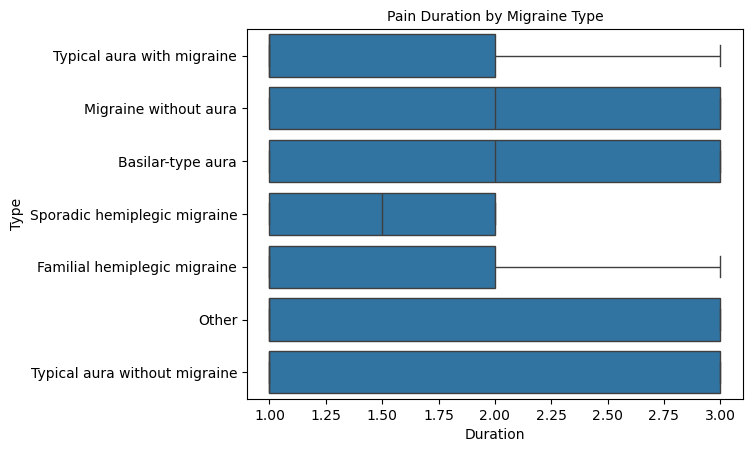

In [9]:
sns.boxplot(data=df, x='Duration', y='Type')
plt.title("Pain Duration by Migraine Type")
plt.show()

**Summary:**  
- ⏱️ `Basilar-type aura`, `Migraine witnout aura`, `Other` and typical aura without migraine show the **longest average pain durations**.  
- 👥 `Sporadic hemiplegic migraine` has the **shortest duration**, suggesting a distinct clinical profile.  
- 📊 Other subtypes fall in the mid‑range, with overlapping symptom durations.


### Pain Frequency by Type

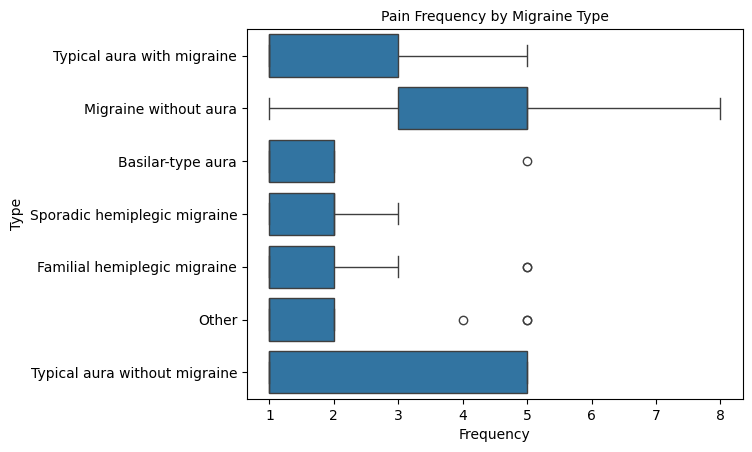

In [10]:
sns.boxplot(data=df, x='Frequency', y='Type')
plt.title("Pain Frequency by Migraine Type")
plt.show()

**Summary:**  
- **Migraine without aura** and **Typical aura with migraine** have the widest range of pain frequencies, while other types show lower, more consistent levels. Outliers indicate a few cases with unusually high pain frequency.



### Intensity by Type

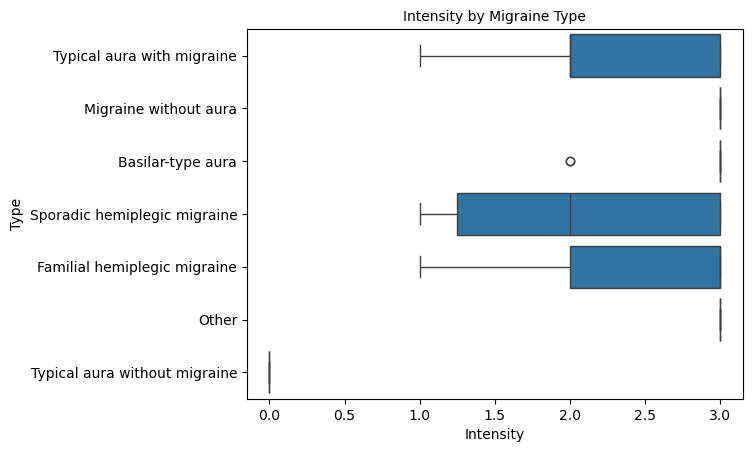

In [11]:
sns.boxplot(data=df, x='Intensity', y='Type')
plt.title("Intensity by Migraine Type")
plt.show()

**Summary**
- Most migraine types have high intensity levels, especially **Typical aura with migraine** and **hemiplegic** types. **Typical aura without migraine** shows minimal intensity, while a few outliers indicate rare variations in other types.

## Pain Characteristics by Type

### Location of Pain

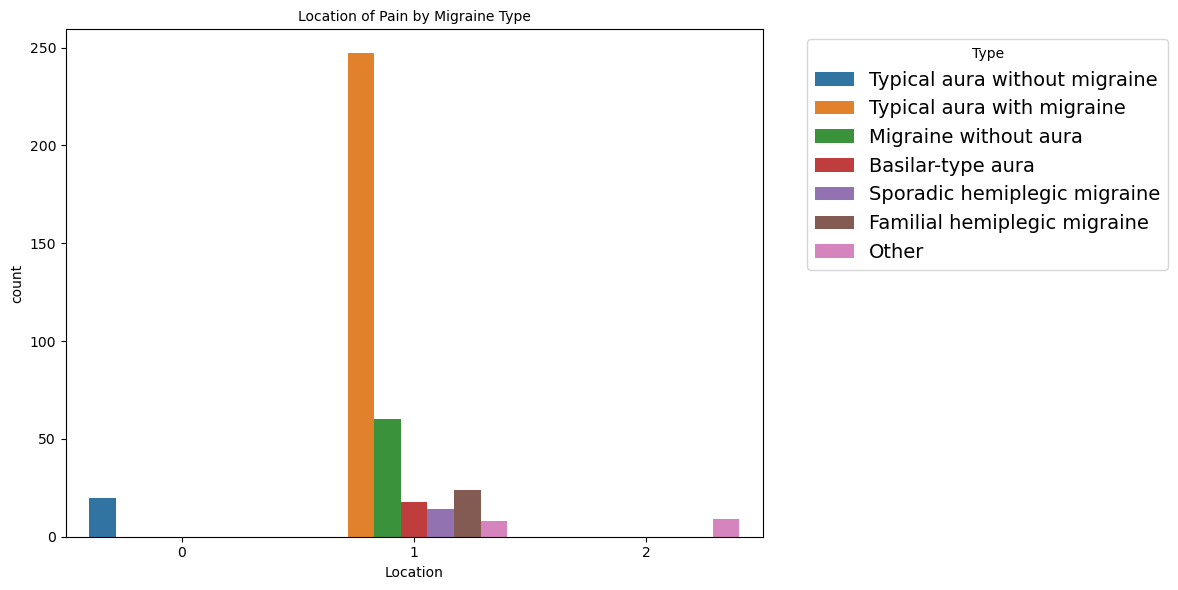

In [12]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Location', hue='Type')
plt.title("Location of Pain by Migraine Type")
plt.legend(title='Type', bbox_to_anchor=(1.05, 1), loc='upper left')  # move legend outside
plt.tight_layout() 
plt.show()

**Summary:**  
- 📍 Pain is most often reported at **Location 1 = Bilateral**, especially among patients with **Typical aura with migraine**, which dominates the counts.  
- 🔎 Locations 0 and 2 are less common and appear mainly in a few other migraine types.


### Character of Pain

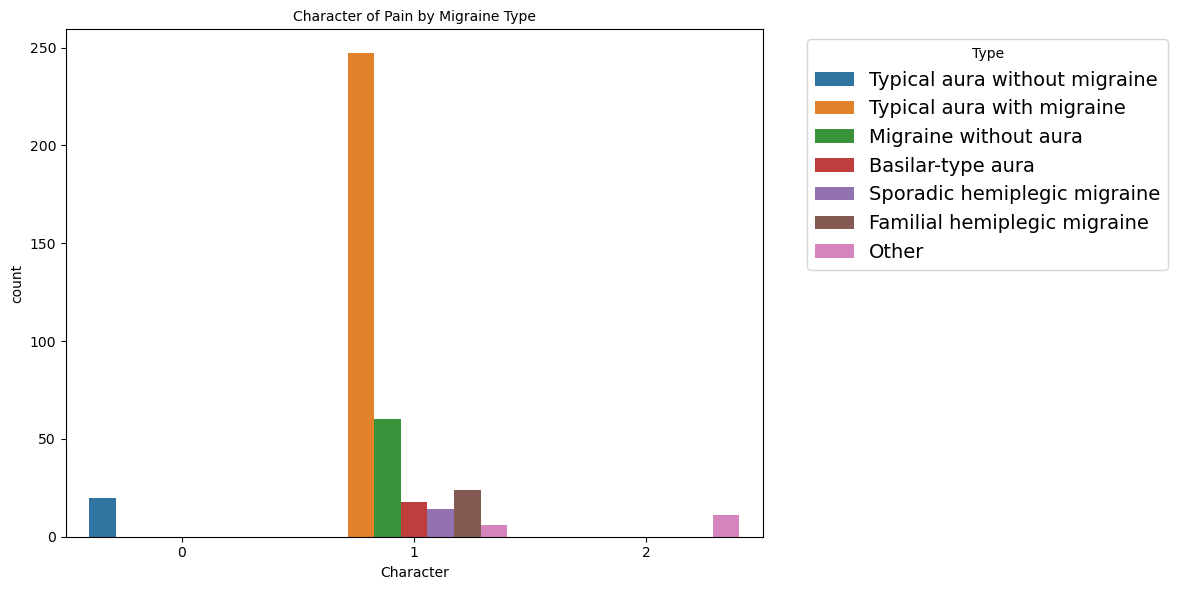

In [13]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Character', hue='Type')
plt.title("Character of Pain by Migraine Type")
plt.legend(title='Type', bbox_to_anchor=(1.05, 1), loc='upper left')  # move legend outside
plt.tight_layout() 
plt.show()

**Summary:**  
- 🔶 **Typical aura with migraine** is most strongly associated with **Character 1 pain= Pressing**, dominating the distribution.  
- ⚖️  Character 0 and 2 are less common and appear mainly in a few other migraine types.

## Correlation Matrix of Numeric Features

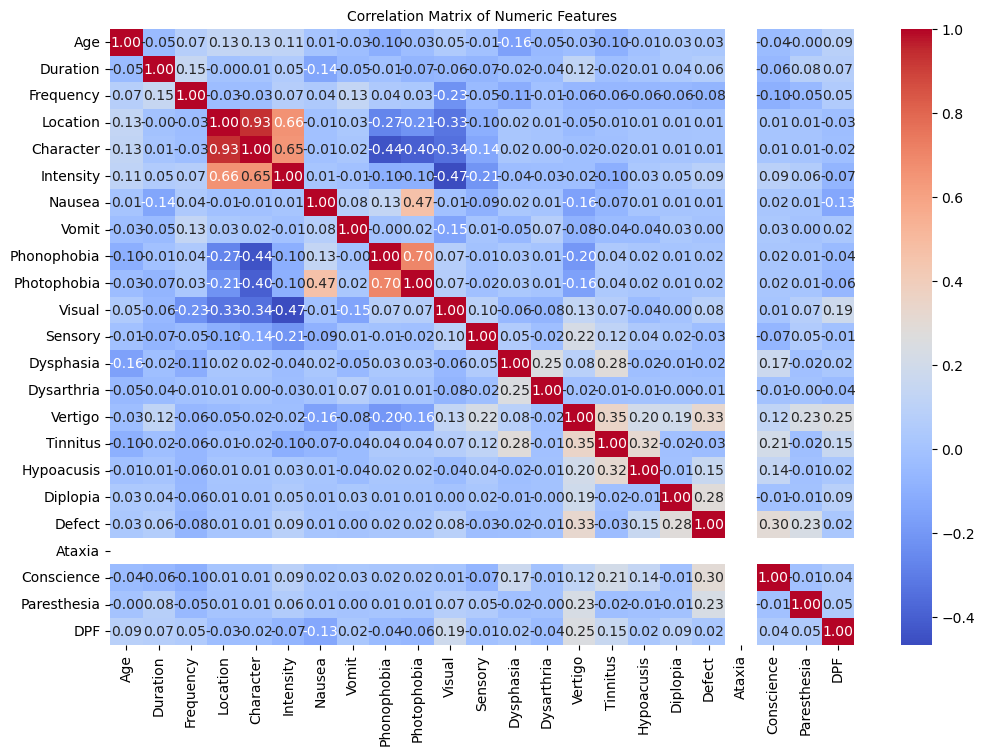

In [14]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix of Numeric Features")
plt.show()

**Key Findings:**  
- 📌 **Strong positive correlations**:  
  - `Photophobia` and `Phonophobia` (~0.69) → frequent co‑occurrence in migraine pathology.  
  - `Location` and `Character` (~0.93) → nearly overlapping information, suggesting potential multicollinearity.  
  - `Defect`, `Diplopia`, and `Vertigo` show moderate links, reflecting shared neurological origins in complex migraine types.  

- ⚠️ **Low correlations**:  
  - Most features are weakly related (|r| < 0.3), confirming a **diverse and complementary feature set**.  
  - This low redundancy increases the value of each symptom for classification.  

- 🚫 **Ataxia**: no correlation with any feature (r = 0), consistent with earlier findings that it carries no signal → will be dropped in preprocessing.



## Data Cleaning Decisions (Drop Ataxia, Binarize Visual/Sensory)

### Dropping 'Ataxia'

In [15]:
df.drop(columns='Ataxia', inplace=True)

### Binarizing Symptom Features

In [16]:
df['Visual'] = df['Visual'].apply(lambda x: 1 if x > 0 else 0)
df['Sensory'] = df['Sensory'].apply(lambda x: 1 if x > 0 else 0)


We dropped `Ataxia` because it showed no variance (always 0, no predictive value), and binarized `Sensory` and `Visual` to capture simple presence/absence of symptoms, reducing noise from low‑frequency counts.

## Final Dataset Structure and Class Breakdown

In this section, we provide a structured profile of the dataset to complement the exploratory plots:

- **Class distribution:** counts and percentages for each migraine type  
- **Imbalance ratios:** majority vs. minority classes  
- **Per-class summary stats:** Age, Duration, Frequency, Intensity  
- **Symptom prevalence by class:** mean presence of each symptom per type  
- **Top predictive symptoms per class:** quick diagnostic cues  

This ensures the dataset’s clinical structure is transparent before moving into preprocessing and modeling.

### Fix column naming and build symptom list

In [17]:
# Ensure clean column names (fix trailing space in 'DPF ')
df = df.rename(columns={'DPF ': 'DPF'})

# Identify non-symptom feature columns
base_cols = ['Age', 'Duration', 'Frequency', 'Location', 'Character', 'Intensity', 'Type']

# Dynamically derive symptom columns from the dataframe
symptom_cols = [c for c in df.columns if c not in base_cols]

# Sanity check
print("Symptom columns:", symptom_cols)


Symptom columns: ['Nausea', 'Vomit', 'Phonophobia', 'Photophobia', 'Visual', 'Sensory', 'Dysphasia', 'Dysarthria', 'Vertigo', 'Tinnitus', 'Hypoacusis', 'Diplopia', 'Defect', 'Conscience', 'Paresthesia', 'DPF']


### Class distribution and percentages

In [18]:
# Counts and percentages by migraine type
class_counts = df['Type'].value_counts().rename('Count')
class_perc = (df['Type'].value_counts(normalize=True) * 100).round(2).rename('Percent')

class_distribution = pd.concat([class_counts, class_perc], axis=1)
class_distribution


,Count,Percent
Type,,
Typical aura with migraine,247,61.75
Migraine without aura,60,15.00
Familial hemiplegic migraine,24,6.00
Typical aura without migraine,20,5.00
Basilar-type aura,18,4.50
Other,17,4.25
Sporadic hemiplegic migraine,14,3.50


### Imbalance summary

In [19]:
# Imbalance metrics: majority/minority
majority_class = class_counts.idxmax()
minority_class = class_counts.idxmin()
imbalance_ratio = (class_counts.max() / class_counts.min())

print(f"Majority class: {majority_class} (n={class_counts.max()})")
print(f"Minority class: {minority_class} (n={class_counts.min()})")
print(f"Imbalance ratio (max/min): {imbalance_ratio:.2f}x")


Majority class: Typical aura with migraine (n=247)
Minority class: Sporadic hemiplegic migraine (n=14)
Imbalance ratio (max/min): 17.64x


### Per-class summary stats for numeric and ordinal features

In [20]:
per_class_stats = (
    df.groupby('Type')[['Age', 'Duration', 'Frequency', 'Intensity']]
      .agg(['mean', 'median', 'std'])
      .round(2)
)
per_class_stats


Age               Duration               \
                                mean median    std     mean median   std   
Type                                                                       
Basilar-type aura              31.56   32.5   8.27     1.94    2.0  0.94   
Familial hemiplegic migraine   21.46   22.0   3.51     1.58    1.0  0.72   
Migraine without aura          33.17   34.0  13.20     1.95    2.0  0.83   
Other                          38.00   40.0  12.66     1.76    1.0  0.97   
Sporadic hemiplegic migraine   21.57   21.0   2.62     1.50    1.5  0.52   
Typical aura with migraine     32.91   30.0  12.37     1.49    1.0  0.70   
Typical aura without migraine  26.60   24.0   7.73     1.70    1.0  0.92   

                              Frequency              Intensity               
                                   mean median   std      mean median   std  
Type                                                                         
Basilar-type aura                  1.61    1.0  0.98      2.89    3.0  0.32  
Familial hemiplegic migraine       1.67    1.0  1.17      2.50    3.0  0.66  
Migraine without aura              4.20    5.0  1.90      3.00    3.0  0.00  
Other                              1.76    1.0  1.44      3.00    3.0  0.00  
Sporadic hemiplegic migraine       1.64    2.0  0.63      2.14    2.0  0.86  
Typical aura with migraine         2.11    1.0  1.42      2.49    2.0  0.52  
Typical aura without migraine      2.50    1.0  1.91      0.00    0.0  0.00

### Symptom prevalence by class (table and optional heatmap)

In [21]:
# Mean presence per symptom per class (0–1 range)
symptom_prevalence = df.groupby('Type')[symptom_cols].mean().round(3)
symptom_prevalence


,Nausea,Vomit,Phonophobia,Photophobia,Visual,Sensory,Dysphasia,Dysarthria,Vertigo,Tinnitus,Hypoacusis,Diplopia,Defect,Conscience,Paresthesia,DPF
Type,,,,,,,,,,,,,,,,
Basilar-type aura,1.000,0.278,1.000,1.000,0.889,0.333,0.000,0.000,0.833,0.389,0.333,0.111,0.333,0.222,0.167,0.667
Familial hemiplegic migraine,1.000,0.208,1.000,1.000,0.875,0.167,0.292,0.000,0.417,0.292,0.000,0.000,0.000,0.083,0.000,1.000
Migraine without aura,1.000,0.600,1.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.300
Other,0.765,0.471,0.471,0.529,0.706,0.294,0.000,0.000,0.471,0.176,0.000,0.000,0.000,0.000,0.000,0.647
Sporadic hemiplegic migraine,1.000,0.429,1.000,1.000,0.857,0.357,0.429,0.071,0.357,0.286,0.000,0.000,0.000,0.000,0.000,0.000
Typical aura with migraine,1.000,0.247,1.000,1.000,0.960,0.243,0.008,0.000,0.024,0.000,0.000,0.000,0.000,0.004,0.000,0.348
Typical aura without migraine,0.950,0.400,1.000,1.000,1.000,0.450,0.000,0.000,0.300,0.150,0.000,0.000,0.000,0.000,0.000,0.650


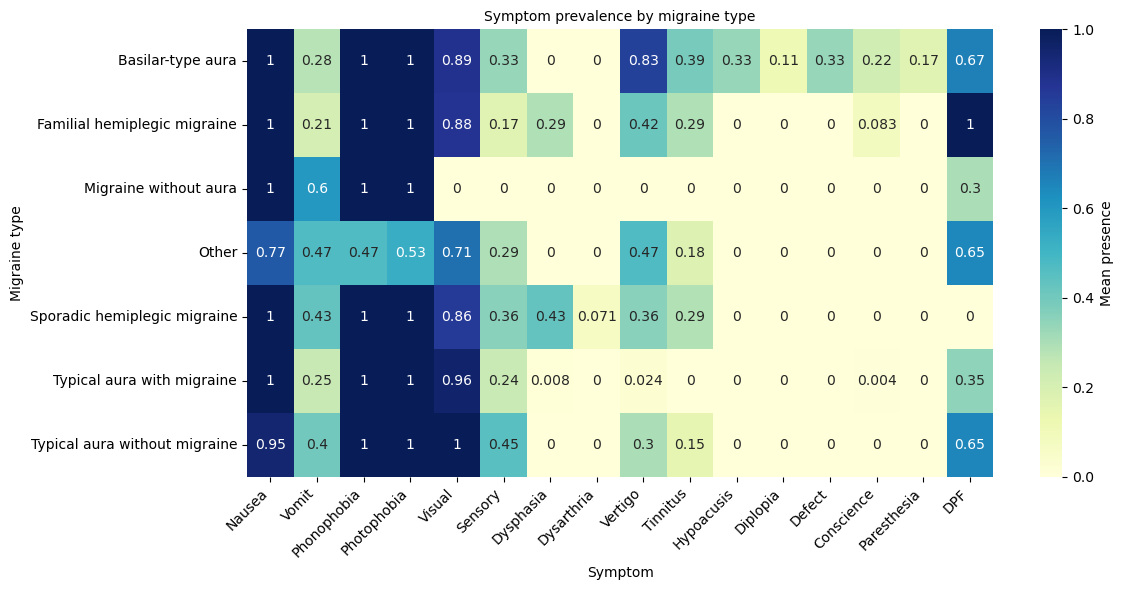

In [22]:
# heatmap for quick visual
plt.figure(figsize=(12, 6))
sns.heatmap(symptom_prevalence, annot=True, cmap='YlGnBu', cbar_kws={'label': 'Mean presence'})
plt.title('Symptom prevalence by migraine type')
plt.xlabel('Symptom')
plt.ylabel('Migraine type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Compact diagnostic summary table (top symptoms per class)

In [23]:
# Top-5 symptoms per class by mean presence
top_symptoms_per_class = {}
for t, row in symptom_prevalence.iterrows():
    top_symptoms = row.sort_values(ascending=False).head(5).index.tolist()
    top_symptoms_per_class[t] = top_symptoms

diagnostic_summary = (
    pd.DataFrame.from_dict(top_symptoms_per_class, orient='index')
      .rename(columns=lambda i: f"Top symptom {i+1}")
)
diagnostic_summary


,Top symptom 1,Top symptom 2,Top symptom 3,Top symptom 4,Top symptom 5
Basilar-type aura,Nausea,Phonophobia,Photophobia,Visual,Vertigo
Familial hemiplegic migraine,Nausea,Phonophobia,Photophobia,DPF,Visual
Migraine without aura,Nausea,Phonophobia,Photophobia,Vomit,DPF
Other,Nausea,Visual,DPF,Photophobia,Phonophobia
Sporadic hemiplegic migraine,Nausea,Phonophobia,Photophobia,Visual,Vomit
Typical aura with migraine,Nausea,Phonophobia,Photophobia,Visual,DPF
Typical aura without migraine,Photophobia,Phonophobia,Visual,Nausea,DPF


# Data Preprocessing and Model Building

## Train-Test Split

In [24]:
X = df.drop('Type', axis=1)
y = df['Type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train: {X_train.shape}, Test: {X_test.shape}, Classes: {y.nunique()}")

Train: (320, 22), Test: (80, 22), Classes: 7


## Define Feature Groups

In [25]:
# Numeric (continuous)
numerical_cols = ['Age', 'Duration', 'Frequency']

# Ordinal numeric (keep numeric order intact)
ordinal_col = ['Intensity']

# Categorical (to OneHot)
categorical_cols = ['Location', 'Character']

# Binary symptom indicators (auto-detect)
binary_cols = [col for col in X.columns if col not in numerical_cols + ordinal_col + categorical_cols ]

## Preprocessing Pipeline (Scaling, Encoding, SMOTE-ready)

**Feature Encoding Key (Categorical Features)**

The `Location` and `Character` features were One-Hot Encoded (`OHE`). The resulting columns are named using a zero-based index (`_0`, `_1`, `_2`) based on the ascending order of the original integer codes.

| Feature | Original Integer Code | Clinical Meaning (App Label) | Final OHE Column |
| :--- | :--- | :--- | :--- |
| **Location** | 1 | **Unilateral** | `Location__0` |
| **Location** | 2 | **Bilateral** | `Location__1` |
| **Location** | 3 | **Frontal** | `Location__2` |
| **Character** | 1 | **Throbbing** | `Character__0` |
| **Character** | 2 | **Pressing** | `Character__1` |
| **Character** | 3 | **Sharp** | `Character__2` |

In [26]:

# Define the preprocessing steps for different column types:
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_cols),  # Standardize numerical columns (zero mean, unit variance)
    ('ord', 'passthrough', ordinal_col),        # Keep ordinal columns unchanged
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),  # One-hot encode categorical columns, ignore unknown values
    ('bin', 'passthrough', binary_cols)         # Keep binary columns unchanged
])

## Logistic Regression Pipeline with SMOTE & Tuning

In [27]:

# Create a pipeline for Logistic Regression that includes preprocessing and SMOTE
logreg_pipe = Pipeline(steps=[
    ('preprocessing', preprocessor),  # Apply the preprocessing steps defined earlier
    ('smote', SMOTE(random_state=42)),  # Apply SMOTE to handle class imbalance
    ('model', LogisticRegression(max_iter=1000, random_state=42))  # Logistic Regression model with increased iterations
])

# Define hyperparameter grid for Logistic Regression
param_grid_logreg = {
    'model__C': [0.01, 0.1, 1, 10],  # Testing different regularization strengths
    'model__penalty': ['l2'],  # Using L2 regularization
    'model__solver': ['lbfgs', 'liblinear']  # Testing different optimization algorithms
}

# Set up GridSearchCV to find the best hyperparameters
grid_search_logreg = GridSearchCV(
    logreg_pipe,
    param_grid_logreg,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=2  # Detailed output during fitting
)

# Train the model with grid search to find optimal hyperparameters
grid_search_logreg.fit(X_train, y_train)

# Extract the best model from grid search results
best_logreg = grid_search_logreg.best_estimator_
# Make predictions on the test set using the best model
lr_pred = best_logreg.predict(X_test)

print("Best LogReg params:", grid_search_logreg.best_params_)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best LogReg params: {'model__C': 10, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}


## Random Forest Pipeline with SMOTE & Hyperparameter Tuning

In [28]:

# Create a pipeline that includes preprocessing, SMOTE for handling class imbalance, and Random Forest classifier
rf_pipe = Pipeline(steps=[
    ('preprocessing', preprocessor),  # Apply the preprocessing steps defined earlier
    ('smote', SMOTE(random_state=42)),  # Apply SMOTE to balance the classes in the training data
    ('model', RandomForestClassifier(random_state=42))  # Initialize the Random Forest classifier
])

# Define hyperparameter grid for Random Forest tuning
param_grid = {
    'model__n_estimators': [100, 200, 300],  # Number of trees in the forest
    'model__max_depth': [None, 5, 10],  # Maximum depth of the trees (None means unlimited)
    'model__min_samples_split': [2, 5],  # Minimum samples required to split an internal node
    'model__min_samples_leaf': [1, 2]  # Minimum samples required to be at a leaf node
}

# Set up GridSearchCV to find the best hyperparameters
grid_search_rf = GridSearchCV(
    rf_pipe,  # Pipeline to optimize
    param_grid,  # Hyperparameter grid
    cv=5,  # 5-fold cross-validation
    scoring='f1_weighted',  # Optimize for weighted F1 score (good for imbalanced classes)
    n_jobs=-1,  # Use all available cores
    verbose=2  # Print progress updates
)

# Fit the grid search to the training data
grid_search_rf.fit(X_train, y_train)

# Get the best model from the grid search
best_rf = grid_search_rf.best_estimator_

# Make predictions on the test set using the best model
rf_preds = best_rf.predict(X_test)

print("Best RF params:", grid_search_rf.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best RF params: {'model__max_depth': 10, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 300}


## XGBoost Pipeline with Label Encoding & Grid Search

In [29]:

# Initialize label encoder to convert categorical target variables to numbers
label_encoder = LabelEncoder()
# Fit the encoder on training data and transform training labels
y_train_encoded = label_encoder.fit_transform(y_train)
# Transform test labels using the fitted encoder
y_test_encoded = label_encoder.transform(y_test)

# Create XGBoost pipeline with preprocessing, SMOTE for class imbalance, and XGBoost classifier
xgb_pipe = Pipeline(steps=[
    ('preprocessing', preprocessor),  # Apply preprocessing steps defined earlier
    ('smote', SMOTE(random_state=42)),  # Apply SMOTE to handle class imbalance
    ('model', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))  # XGBoost classifier
])

# Define hyperparameter search space for XGBoost
param_grid_xgb = {
    'model__n_estimators': [100, 200],  # Number of trees in the forest
    'model__max_depth': [3, 5, 7],  # Maximum depth of each tree
    'model__learning_rate': [0.01, 0.1, 0.2],  # Step size shrinkage to prevent overfitting
    'model__subsample': [0.8, 1.0]  # Fraction of samples used for fitting trees
}

# Set up GridSearchCV to find optimal hyperparameters
grid_search_xgb = GridSearchCV(
    xgb_pipe,  # Pipeline to optimize
    param_grid_xgb,  # Hyperparameter grid
    cv=5,  # 5-fold cross-validation
    scoring='f1_weighted',  # Optimization metric (F1 score with class weighting)
    n_jobs=-1,  # Use all available CPU cores
    verbose=2  # Display detailed progress information
)

# Train the model with grid search
grid_search_xgb.fit(X_train, y_train_encoded)

# Get the best model from grid search
best_xgb = grid_search_xgb.best_estimator_

# Make predictions on test data
xgb_preds = best_xgb.predict(X_test)

# Convert numeric predictions back to original class labels
xgb_preds_named = label_encoder.inverse_transform(xgb_preds)

print("Best XGB params:", grid_search_xgb.best_params_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


C:\Users\user\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:39:14] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGB params: {'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100, 'model__subsample': 1.0}


## Optimal Hyperparameters (Summary Table)

In [30]:
pd.set_option('display.max_colwidth', None)
params_summary = pd.DataFrame({
    'Model': ['LogisticRegression', 'RandomForest', 'XGBoost'],
    'BestParams': [
        grid_search_logreg.best_params_,
        grid_search_rf.best_params_, 
        grid_search_xgb.best_params_]
})
params_summary

,Model,BestParams
0,LogisticRegression,"{'model__C': 10, 'model__penalty': 'l2', 'model__solver': 'lbfgs'}"
1,RandomForest,"{'model__max_depth': 10, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 300}"
2,XGBoost,"{'model__learning_rate': 0.1, 'model__max_depth': 3, 'model__n_estimators': 100, 'model__subsample': 1.0}"


## 🧠 Best Model Configurations from Grid Search

Extracted the top-performing hyperparameters from grid searches across all three models:

**🔍 Logistic Regression**
- Regularization: `C = 10`
- Penalty: `l2`
- Solver: `lbfgs`
→ Indicates stronger regularization was best (higher `C`), using a robust solver suitable for medium-sized datasets.

**🌲 Random Forest**
- `n_estimators = 300`: Larger ensemble for improved stability.
- `max_depth = 10`: Limits overfitting while capturing tree depth.
- `min_samples_split = 5`, `min_samples_leaf = 1`: Fine-grained splits to capture complex patterns.

**⚡ XGBoost**
- `learning_rate = 0.1`: Balanced learning pace.
- `max_depth = 3`: Shallow trees to prevent overfitting and improve generalization.
- `n_estimators = 100`: Efficient ensemble size.
- `subsample = 1.0`: Uses full data per boosting round.

These settings reflect well-tuned models that balance performance with interpretability—ready to be benchmarked via metrics and SHAP analysis.


# Model Evaluation

## Evaluate Each Model on Test Set

Test Set Evaluation (Accuracy, F1, Confusion Matrices)

In [31]:

def evaluate_model(name, model, X_test, y_test):
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    f1 = f1_score(y_test, preds, average='weighted')
    print(f"📌 {name}")
    print(f"  Accuracy      : {acc:.4f}")
    print(f"  Weighted F1   : {f1:.4f}")
    disp = ConfusionMatrixDisplay(confusion_matrix(y_test, preds), display_labels=label_encoder.classes_)
    disp.plot(cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xticks(rotation=75)
    plt.show()


📌 Logistic Regression
  Accuracy      : 0.9125
  Weighted F1   : 0.9245


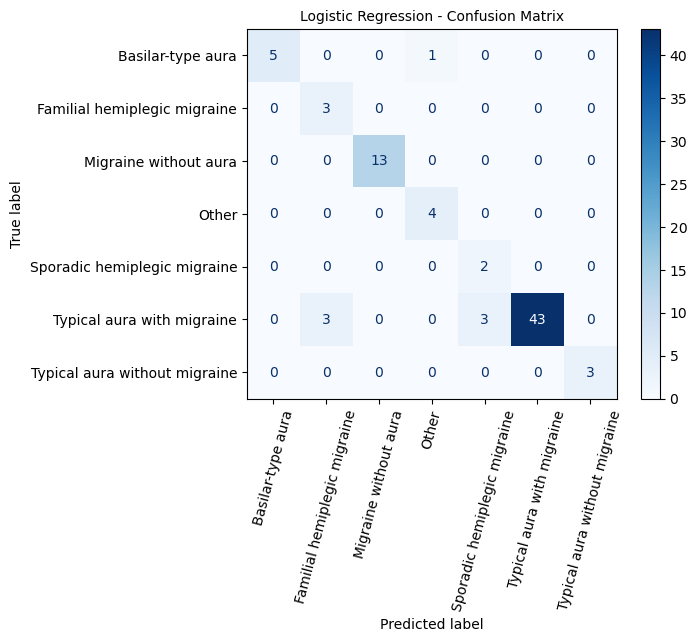

📌 Random Forest
  Accuracy      : 0.9500
  Weighted F1   : 0.9524


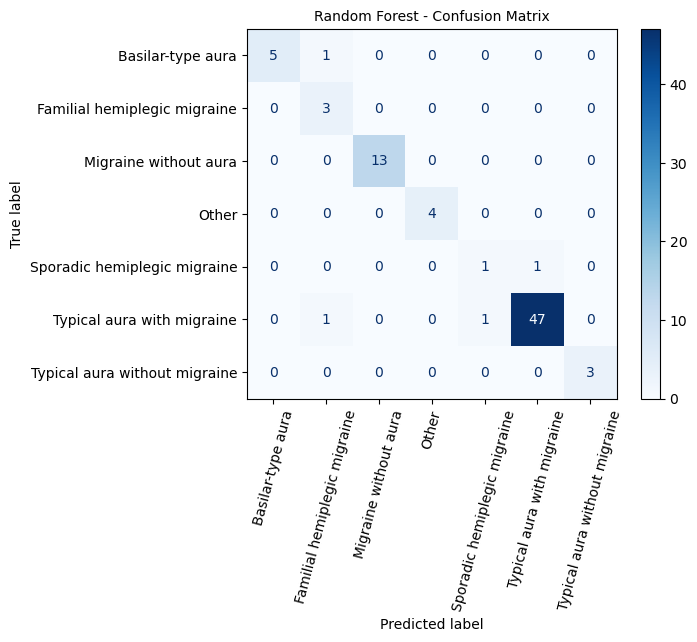

📌 XGBoost
  Accuracy      : 0.9000
  Weighted F1   : 0.9007


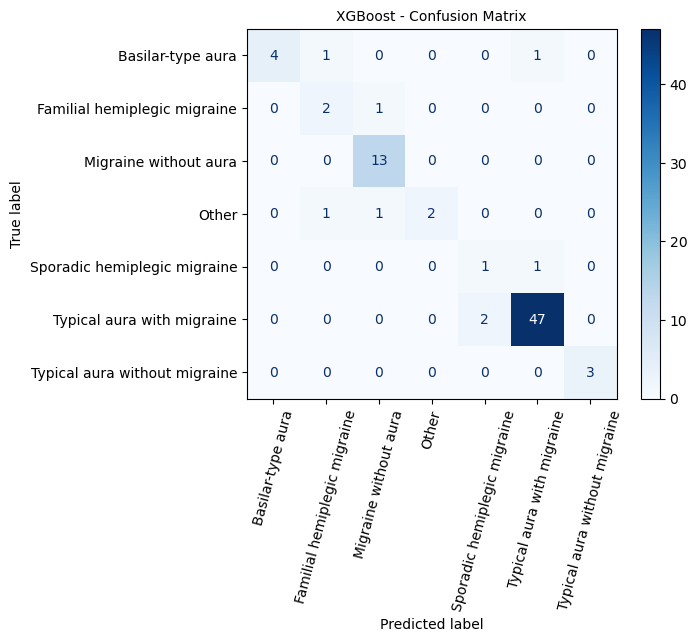

In [32]:
# Evaluate the performance of Logistic Regression model on the test set
evaluate_model("Logistic Regression", best_logreg, X_test, y_test)

# Evaluate the performance of the best Random Forest model on the test set
evaluate_model("Random Forest", best_rf, X_test, y_test)

# Evaluate the performance of XGBoost model on the test set
# Note: XGBoost requires encoded labels rather than string labels
evaluate_model("XGBoost", best_xgb, X_test, y_test_encoded)  # note: encoded labels for XGB

## 📊 Comparative Results & Benchmarks


In [33]:
#from sklearn.metrics import accuracy_score, f1_score

def evaluate_model(name, model, X_test, y_test):
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)
    f1_weighted = f1_score(y_test, preds, average='weighted')
    f1_macro = f1_score(y_test, preds, average='macro')
    return {"Model": name, "Accuracy": acc, "F1_weighted": f1_weighted, "F1_macro": f1_macro}

results = []
results.append(evaluate_model("Logistic Regression", best_logreg, X_test, y_test))
results.append(evaluate_model("Random Forest", best_rf, X_test, y_test))
results.append(evaluate_model("XGBoost", best_xgb, X_test, y_test_encoded))  # encoded labels for XGB

benchmark_df = pd.DataFrame(results).round(3)
benchmark_df


,Model,Accuracy,F1_weighted,F1_macro
0,Logistic Regression,0.912,0.924,0.853
1,Random Forest,0.950,0.952,0.875
2,XGBoost,0.900,0.901,0.761




| Model               | Accuracy | Weighted F1 | Macro F1 |
|---------------------|----------|-------------|----------|
| Logistic Regression | 0.912    | 0.924       | 0.853    |
| Random Forest       | 0.950    | 0.952       | 0.875    |
| XGBoost             | 0.900    | 0.901       | 0.761    |

**Insights:**
- ✅ **Random Forest** delivers the strongest overall performance, with both the highest accuracy and balanced per-class F1.  
- ⚖️ **Logistic Regression** performs surprisingly well, confirming that symptom features are predictive even under linear boundaries.  
- ⚡ **XGBoost** performs well on frequent classes but struggles with rare subtypes, likely due to shallow depth (max_depth=3).  

**Confusion Matrix Patterns:**
- All models classify *Migraine without aura* and *Typical aura without migraine* perfectly.  
- Random Forest is most consistent on *Typical aura with migraine*.  
- Rare classes (*Familial* and *Sporadic hemiplegic migraine*) remain challenging across models.  

**Conclusion:** Random Forest is selected as the best model for further interpretability and SHAP analysis.





## Cross-Validation for Generalization

To assess stability and generalization beyond a single train/test split, we performed **5‑fold cross‑validation** on the training set for each model.  
We report the mean weighted F1 score and its standard deviation across folds.

- **Mean F1** → central tendency of performance.  
- **Std deviation** → stability of the model across different folds.  

In [34]:
def cross_validate_model(name, model, X, y):
    scores = cross_val_score(model, X, y, cv=5, scoring='f1_weighted')
    print(f"📊 {name} Cross-Validated F1 Scores: {scores}")
    print(f"  ➤ Mean F1 Score  : {scores.mean():.4f}")
    print(f"  ➤ Std Deviation : {scores.std():.4f}")


In [35]:
cross_validate_model("Logistic Regression", best_logreg, X_train, y_train)
cross_validate_model("Random Forest", best_rf, X_train, y_train)
cross_validate_model("XGBoost", best_xgb, X_train, y_train_encoded)


📊 Logistic Regression Cross-Validated F1 Scores: [0.88123855 0.90702042 0.86836623 0.81909954 0.83802642]
  ➤ Mean F1 Score  : 0.8628
  ➤ Std Deviation : 0.0311
📊 Random Forest Cross-Validated F1 Scores: [0.83642881 0.88927696 0.87935329 0.84937771 0.89461649]
  ➤ Mean F1 Score  : 0.8698
  ➤ Std Deviation : 0.0229


C:\Users\user\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:39:21] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\user\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:39:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\user\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:39:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
C:\Users\user\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:39:22] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain,

📊 XGBoost Cross-Validated F1 Scores: [0.80848214 0.91294643 0.90284553 0.86878307 0.90827133]
  ➤ Mean F1 Score  : 0.8803
  ➤ Std Deviation : 0.0391


**📊 Results Summary**

| Model               | Mean F1 | Std Dev |
|---------------------|---------|---------|
| Logistic Regression | 0.863   | 0.031   |
| Random Forest       | 0.870   | 0.023   |
| XGBoost             | 0.880   | 0.039   |

**🧠 Interpretation**
- ⚡ **XGBoost** shows the highest average F1, suggesting strong generalization, though with slightly higher variability.  
- ✅ **Random Forest** is the most consistent (lowest std deviation), indicating reliable predictions across folds.  
- 🧮 **Logistic Regression** remains competitive, validating the predictive strength of linear boundaries in symptom space.  


## 🔍 Interpretability & Confidence Analysis /with shap

To improve transparency, we add:
- **Confidence scoring**: probability of the predicted class  
- **Response analysis**: confusion matrix and per-class metrics  
- **Validation examples**: sample predictions with top contributing symptoms (via SHAP)


### Confidence scoring

In [36]:
# Predicted probabilities and confidence scores
probs = best_rf.predict_proba(X_test)
confidences = probs.max(axis=1)

preds = best_rf.predict(X_test)
confidence_df = pd.DataFrame({
    "True": y_test,
    "Predicted": preds,
    "Confidence": confidences.round(3)
})
confidence_df.head(10)


,True,Predicted,Confidence
209,Typical aura with migraine,Typical aura with migraine,0.763
280,Typical aura with migraine,Typical aura with migraine,0.806
33,Migraine without aura,Migraine without aura,0.913
210,Typical aura with migraine,Typical aura with migraine,0.933
93,Typical aura with migraine,Typical aura with migraine,0.942
84,Typical aura with migraine,Typical aura with migraine,0.887
329,Familial hemiplegic migraine,Familial hemiplegic migraine,0.572
94,Typical aura with migraine,Typical aura with migraine,0.942
266,Typical aura with migraine,Sporadic hemiplegic migraine,0.697
126,Typical aura with migraine,Typical aura with migraine,0.776


### Per-class metrics and confusion matrix

Classification Report:

                               precision    recall  f1-score   support

            Basilar-type aura       1.00      0.83      0.91         6
 Familial hemiplegic migraine       0.60      1.00      0.75         3
        Migraine without aura       1.00      1.00      1.00        13
                        Other       1.00      1.00      1.00         4
 Sporadic hemiplegic migraine       0.50      0.50      0.50         2
   Typical aura with migraine       0.98      0.96      0.97        49
Typical aura without migraine       1.00      1.00      1.00         3

                     accuracy                           0.95        80
                    macro avg       0.87      0.90      0.88        80
                 weighted avg       0.96      0.95      0.95        80



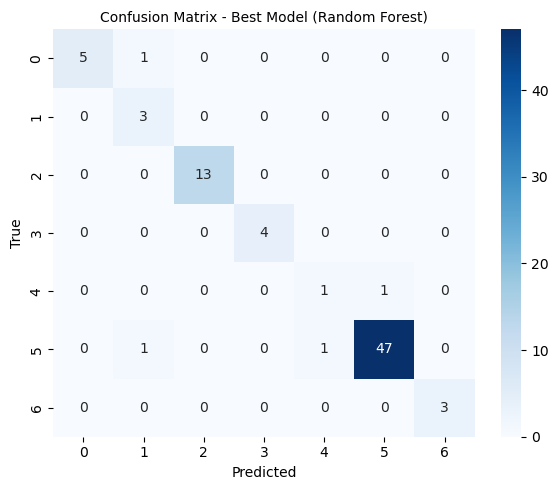

In [37]:
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:\n")
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Best Model (Random Forest)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


### Feature Name Mapping for Interpretability

In [38]:
name_map = {
    "num__Age": 'Age', 
    "num__Duration": 'Duration',
    "num__Frequency": 'Frequency', 
    "ord__Intensity": 'Intensity',
    "cat__Location_0": 'Location = Unilateral', 
    "cat__Location_1": 'Location = Bilateral', 
    "cat__Location_2": 'Location = Frontal',
    "cat__Character_0": 'Character = Throbbing',
    "cat__Character_1": 'Character = Pressing', 
    "cat__Character_2": 'Character = Sharp',
    "bin__Nausea": 'Nausea', 
    "bin__Vomit": 'Vomit', 
    "bin__Phonophobia": 'Phonophobia',
    "bin__Photophobia": 'Photophobia', 
    "bin__Visual": 'Visual', 
    "bin__Sensory": 'Sensory',
    "bin__Dysphasia": 'Dysphasia', 
    "bin__Dysarthria": 'Dysarthria', 
    "bin__Vertigo": 'Vertigo',
    "bin__Tinnitus": 'Tinnitus', 
    "bin__Hypoacusis":'Hypoacusis',
    "bin__Diplopia": 'Diplopia', 
    "bin__Defect": 'Defect',
    "bin__Conscience": 'Conscience',
    "bin__Paresthesia": 'Paresthesia', 
    "bin__DPF": 'DPF'
    # ... add the rest
}

# Apply mapping to feature names
feature_names = best_rf.named_steps['preprocessing'].get_feature_names_out()
friendly_names = [name_map.get(f, f) for f in feature_names]


### Global feature importance (model-based)

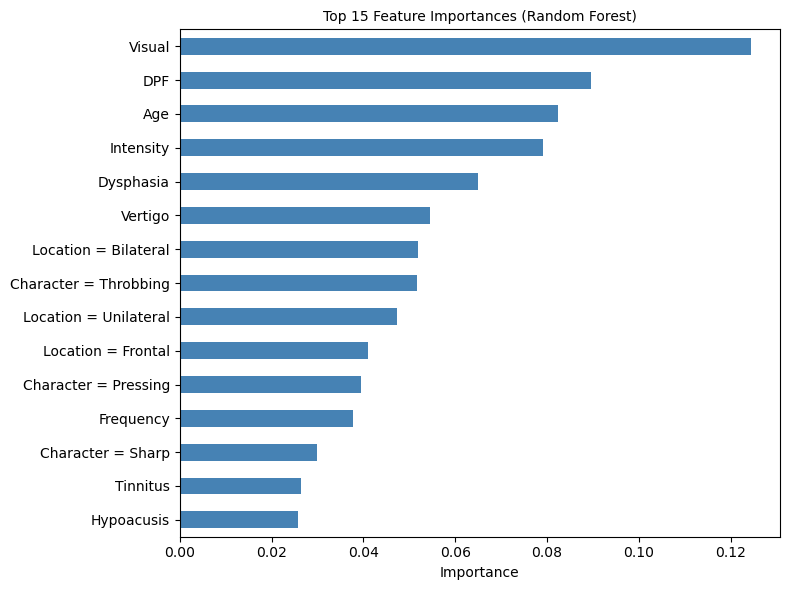

In [42]:
# Random Forest feature importances (best_rf)
rf_model = best_rf.named_steps['model']

importances = pd.Series(rf_model.feature_importances_, index=friendly_names).sort_values(ascending=False)

plt.figure(figsize=(8,6))
importances.head(15).plot(kind='barh', color="steelblue")
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


**Summary:**  
- 🌟 **Visual symptoms** are the most influential predictor, followed by **DPF**, **Age**, and **Intensity**, which together dominate the model’s decision‑making.  
- 🧠 **Language and balance features** (Dysphasia, Vertigo) also rank highly, reflecting their clinical relevance in complex migraine types.  
- 📍 Pain descriptors (Location, Character) and **Frequency** contribute moderately, while auditory symptoms (Tinnitus, Hypoacusis) play a smaller but non‑negligible role.  
- ⚖️ The mix of symptom, demographic, and pain‑profile features shows the model is leveraging **both clinical presentation and patient context** for classification.


### SHAP global summary

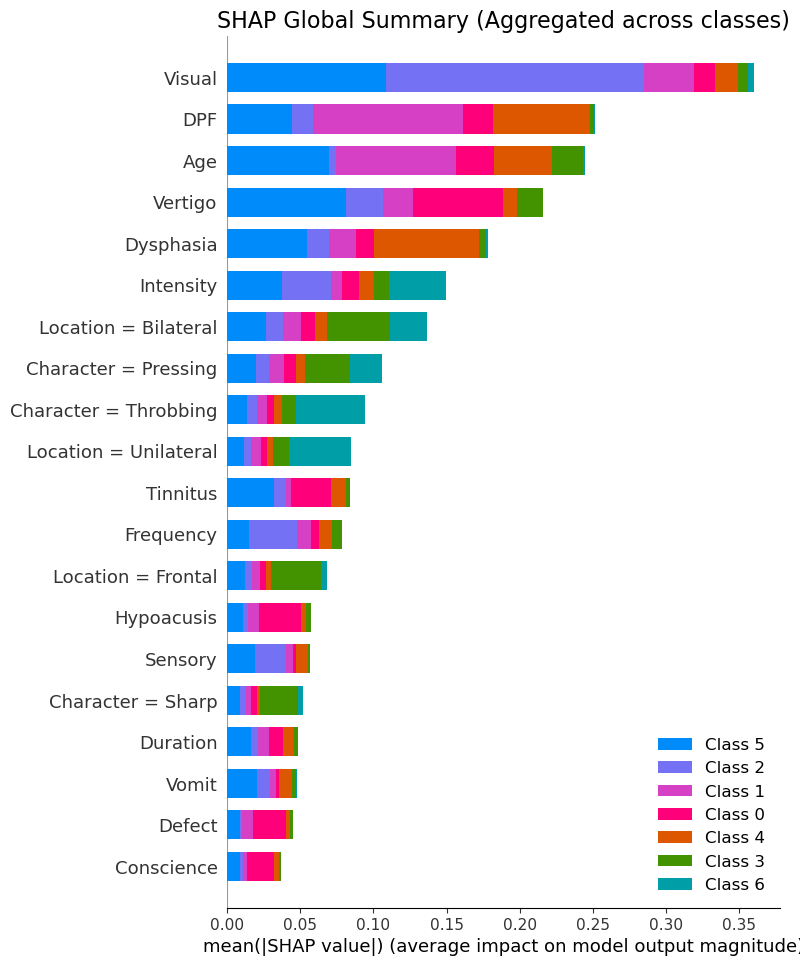

In [47]:

# Transform test set
X_test_transformed = best_rf.named_steps['preprocessing'].transform(X_test)

#  Build explainer on the fitted RF model
explainer = shap.TreeExplainer(rf_model)

#  Get SHAP values (multiclass → list of arrays, one per class)
shap_values_test = explainer.shap_values(X_test_transformed)

#  Global summary: show for the predicted class per sample (aggregated)
# Compute mean(|SHAP|) across classes for a single global ranking
if isinstance(shap_values_test, list):
    # Stack [n_classes, n_samples, n_features] → aggregate mean(|shap|) over classes
    shap_stack = np.stack([np.abs(sv) for sv in shap_values_test])  # (C, N, F)
    shap_global = shap_stack.mean(axis=0)                           # (N, F)
else:
    shap_global = np.abs(shap_values_test)

# Summary plot using aggregated SHAP magnitudes
plt.figure(figsize=(14,8))
shap.summary_plot(shap_global, X_test_transformed, feature_names=friendly_names, plot_type='bar', show=False)
plt.title("SHAP Global Summary (Aggregated across classes)", fontsize=16, loc='center')
#plt.tight_layout()
plt.show()


**Summary:**  
- 🔗 The plot highlights **interaction effects** between features, showing how combinations (e.g., Age × Frequency, Location × Character) influence predictions beyond individual contributions.  
- 📍 Strong interactions appear between **pain descriptors** (Location and Character) and between **demographics and symptom frequency**, suggesting the model captures clinically meaningful pairings.  
- ⚖️ Most other features show weaker interactions, reinforcing that while single features drive predictions, certain **feature pairs provide additional discriminative power**.


### SHAP class-specific summaries


Class: Basilar-type aura


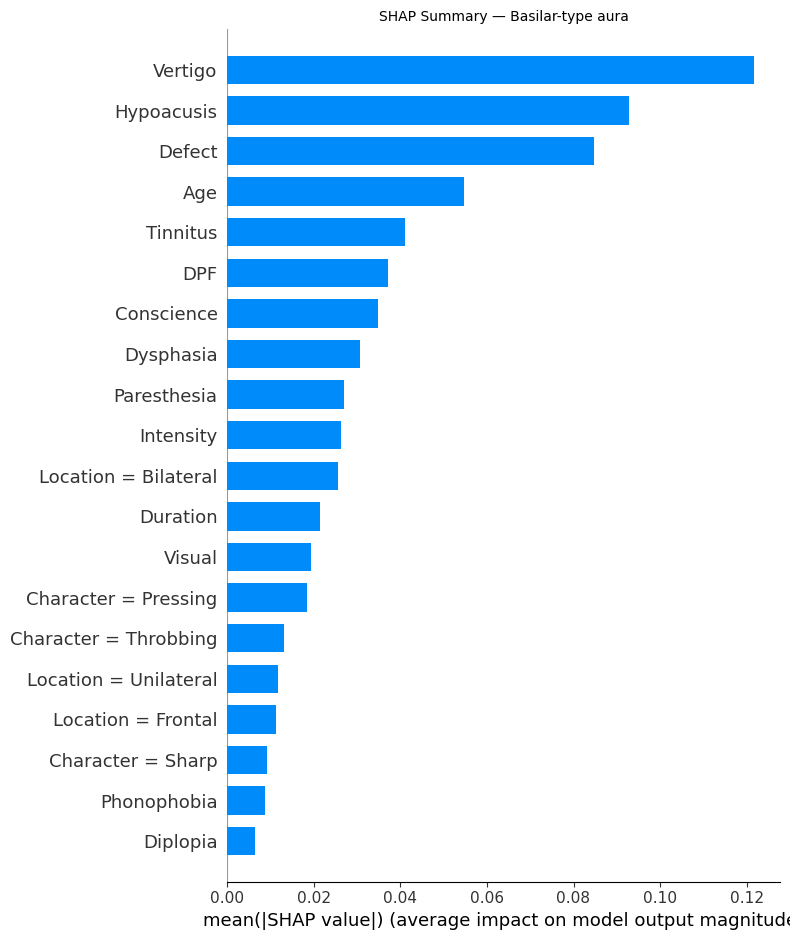


Class: Familial hemiplegic migraine


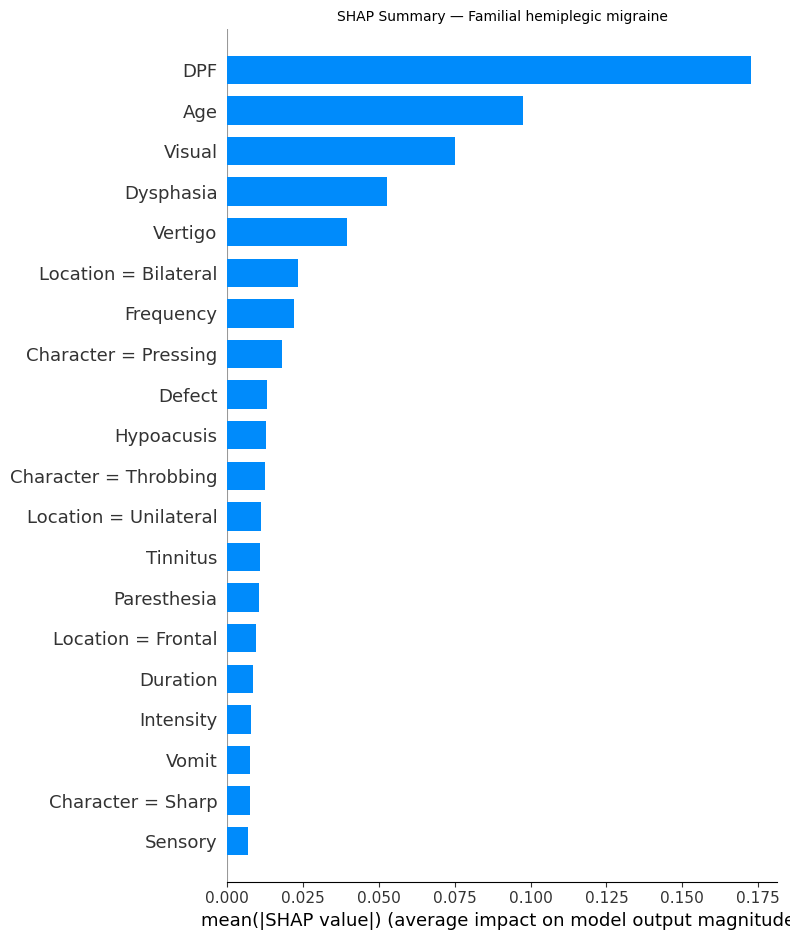


Class: Migraine without aura


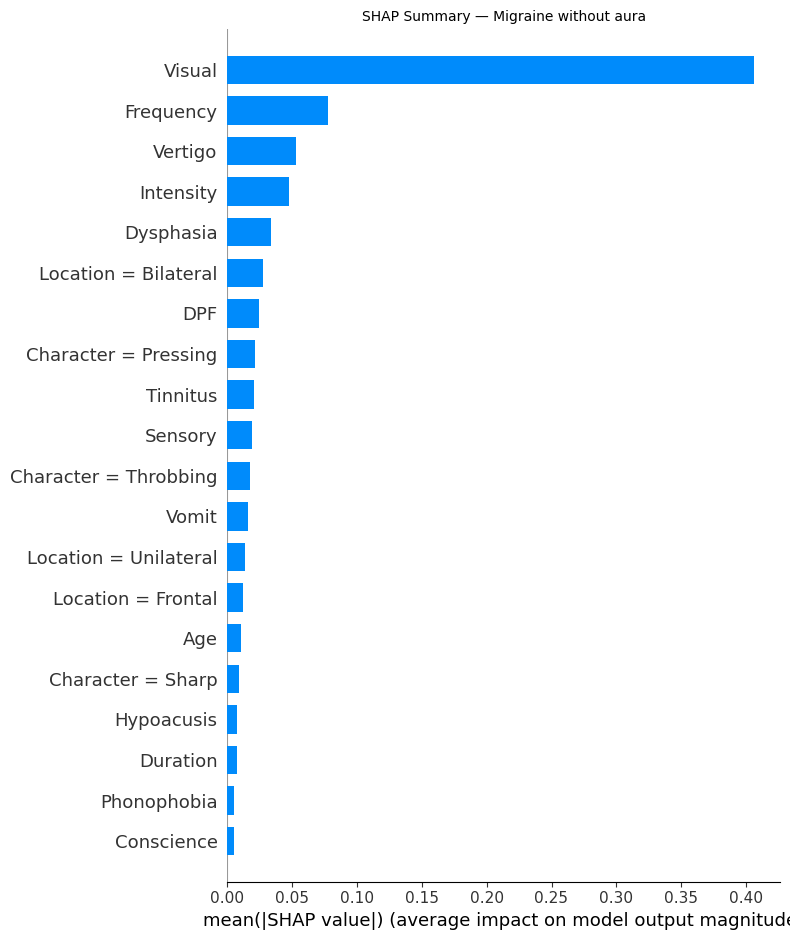


Class: Other


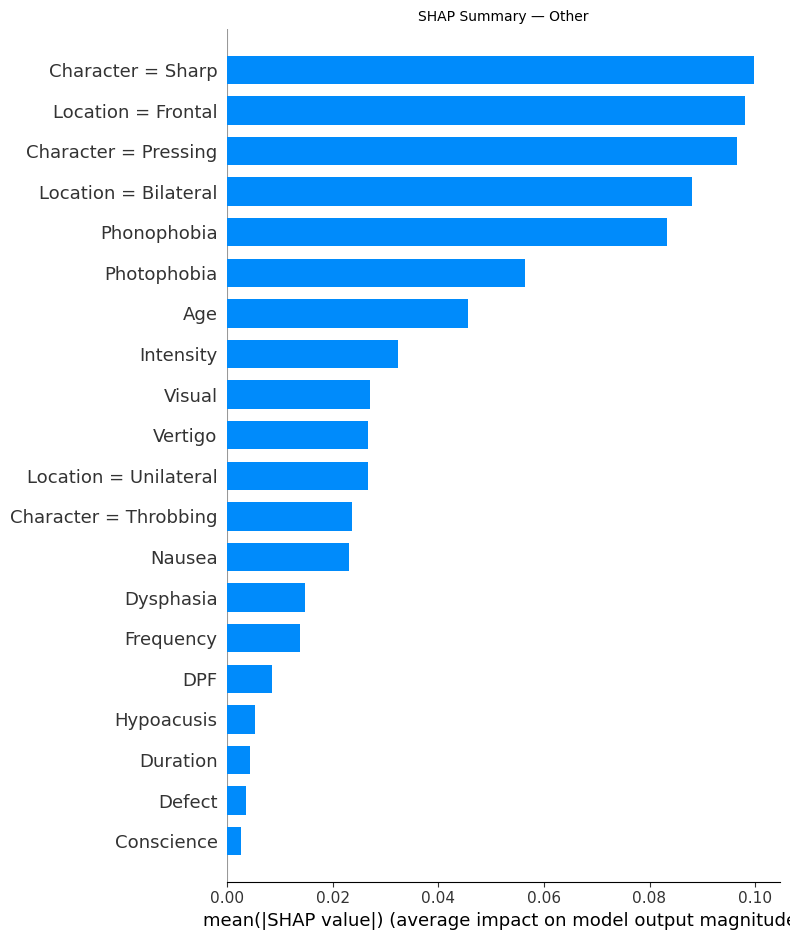


Class: Sporadic hemiplegic migraine


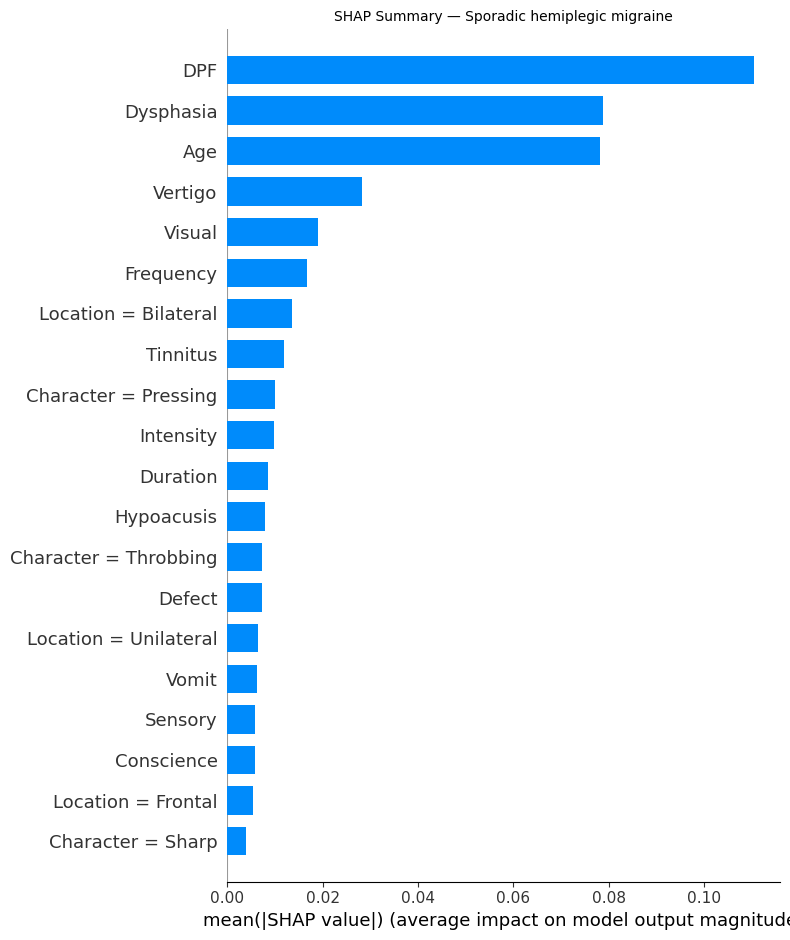


Class: Typical aura with migraine


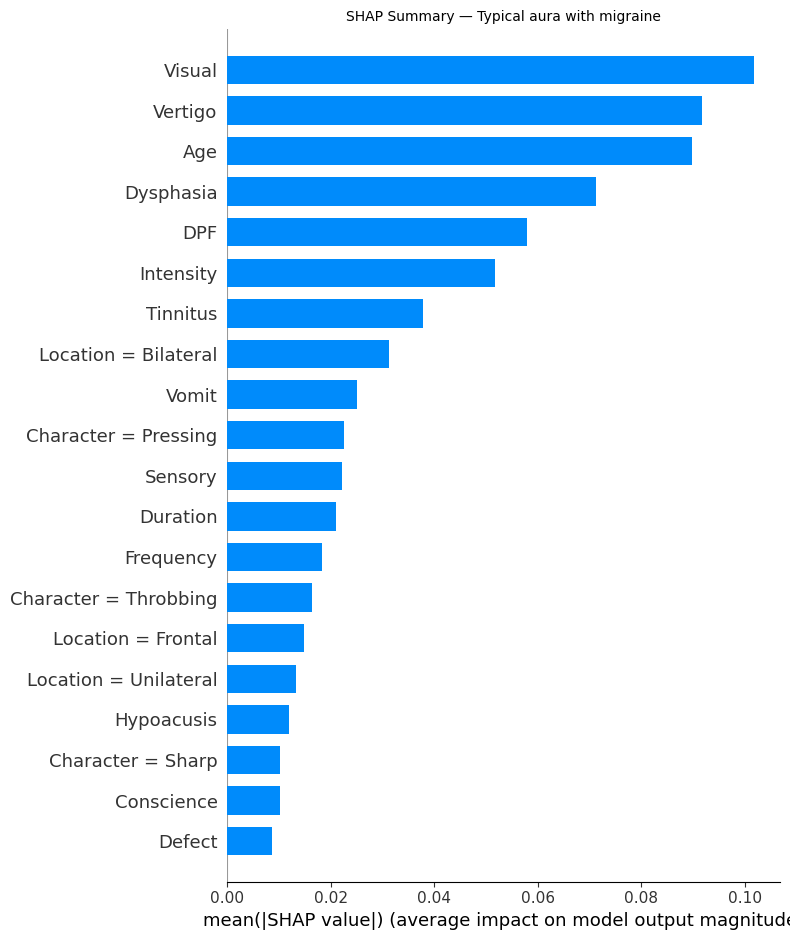


Class: Typical aura without migraine


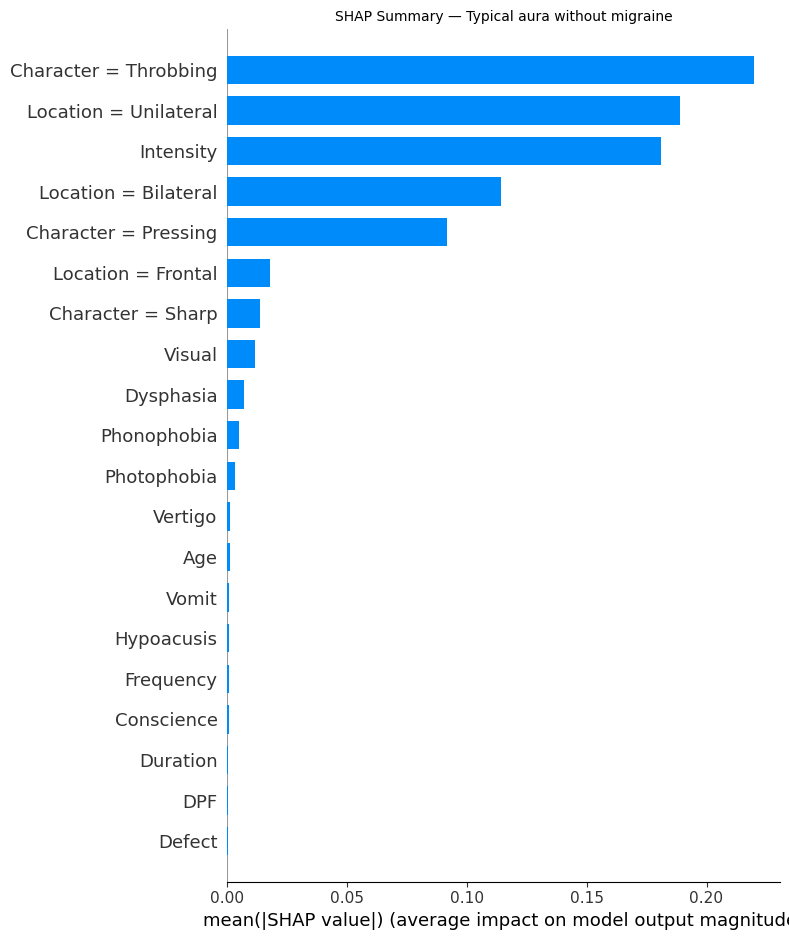

In [48]:
# 4.4.5 SHAP Class-Specific Summaries (robust to SHAP version)
classes = list(rf_model.classes_)

# Case 1: shap_values is a list (older SHAP versions)
if isinstance(shap_values_test, list):
    for i, cls in enumerate(classes):
        print(f"\nClass: {cls}")
        idx_cls = np.where(np.array(y_test) == cls)[0]
        X_cls = X_test_transformed[idx_cls] if len(idx_cls) > 0 else X_test_transformed
        shap_cls = shap_values_test[i][idx_cls] if len(idx_cls) > 0 else shap_values_test[i]

        shap.summary_plot(shap_cls, X_cls, feature_names=friendly_names, show=False)
        plt.title(f"SHAP Summary — {cls}")
        plt.tight_layout()
        plt.show()

# Case 2: shap_values is a single array (newer SHAP versions)
elif isinstance(shap_values_test, np.ndarray) and shap_values_test.ndim == 3:
    # shape = (n_samples, n_features, n_classes)
    for i, cls in enumerate(classes):
        print(f"\nClass: {cls}")
        idx_cls = np.where(np.array(y_test) == cls)[0]
        X_cls = X_test_transformed[idx_cls] if len(idx_cls) > 0 else X_test_transformed
        shap_cls = shap_values_test[idx_cls, :, i] if len(idx_cls) > 0 else shap_values_test[:, :, i]

        shap.summary_plot(shap_cls, X_cls, feature_names=friendly_names, plot_type='bar', show=False)
        plt.title(f"SHAP Summary — {cls}")
        plt.tight_layout()
        plt.show()

else:
    raise ValueError("Unexpected SHAP output format. Check SHAP version and model type.")



### Local explanation (force plot for one sample)

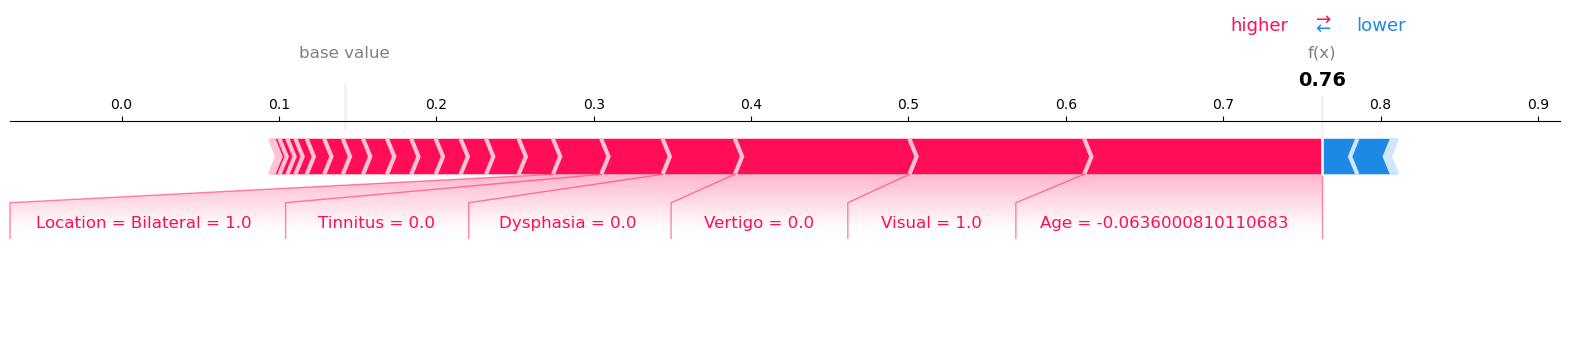

In [49]:
# Get feature names from fitted preprocessor
#feature_names = best_rf.named_steps['preprocessing'].get_feature_names_out()

# Wrap transformed test set in a DataFrame
X_test_df = pd.DataFrame(X_test_transformed, columns=friendly_names)

# Pick a sample
i = 0
pred_class = preds[i]
class_index = list(rf_model.classes_).index(pred_class)

# Force plot with feature names + values
shap.force_plot(
    explainer.expected_value[class_index],
    shap_values_test[i, :, class_index],
    X_test_df.iloc[i, :],   # 👈 DataFrame row, not raw array
    matplotlib=True
)


### Aggregated SHAP across classes (mean abs values)

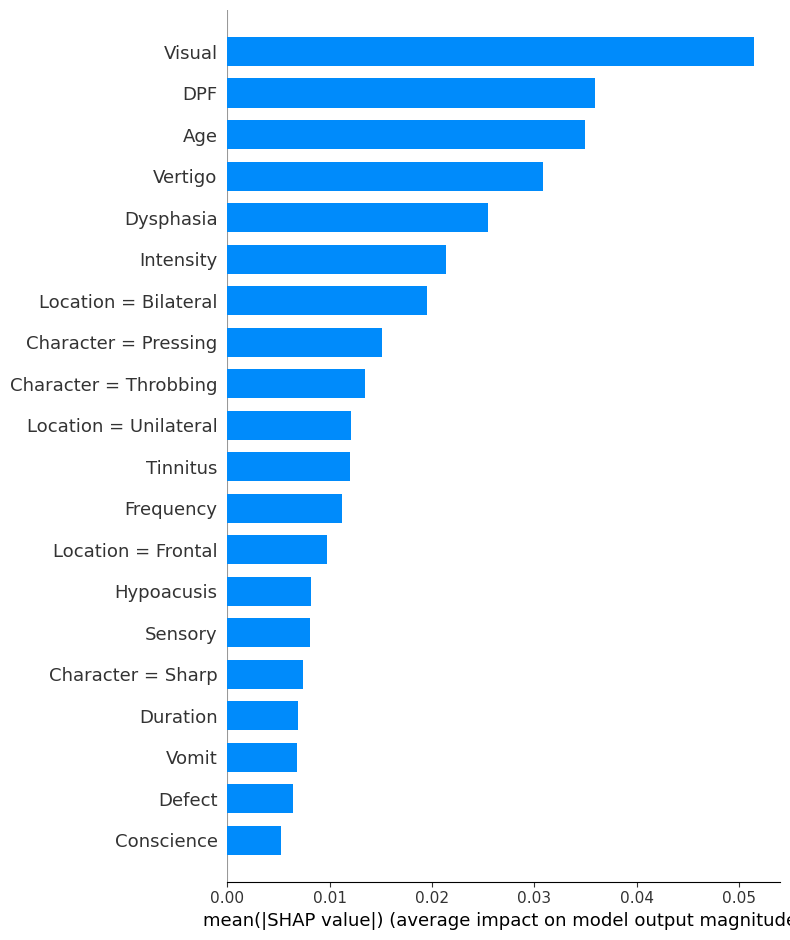

In [50]:

# Collapse across classes: mean absolute SHAP values
shap_values_global = np.mean(np.abs(shap_values_test), axis=2)  # shape: (80, 26)

# Get feature names from preprocessing
#feature_names = best_rf.named_steps['preprocessing'].get_feature_names_out()

# Plot global summary
shap.summary_plot(
    shap_values_global,
    X_test_transformed,
    feature_names=friendly_names,
    plot_type='bar'
)


### Top 10 features

In [51]:

# Get feature names
#feature_names = best_rf.named_steps['preprocessing'].get_feature_names_out()

# Compute mean absolute SHAP values per feature per class
mean_shap_per_class = np.mean(np.abs(shap_values_test), axis=0)  # shape: (26, 7)

# Convert to DataFrame for plotting
df_shap = pd.DataFrame(mean_shap_per_class, 
                       index=friendly_names, 
                       columns=rf_model.classes_)


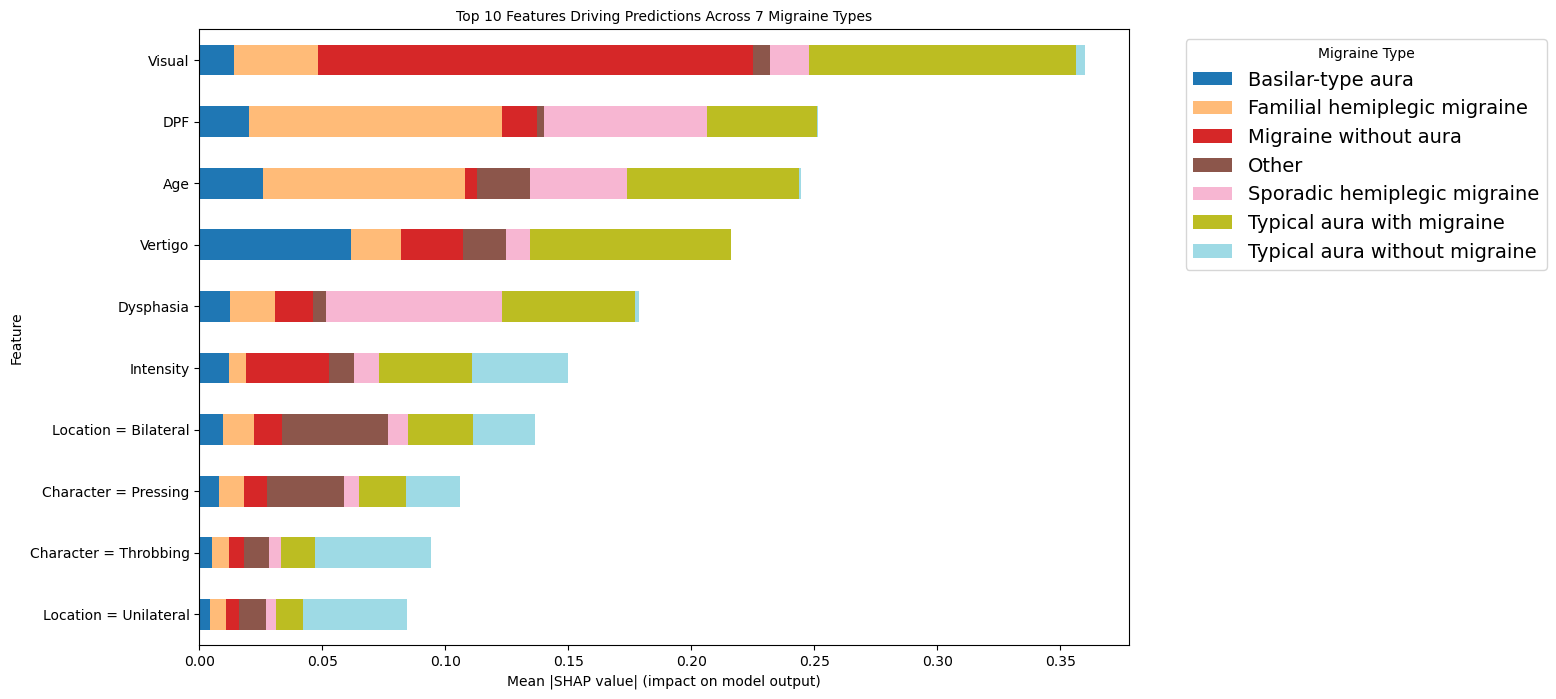

In [52]:
# Sort features by overall importance
df_shap['mean_overall'] = df_shap.mean(axis=1)
df_shap_sorted = df_shap.sort_values('mean_overall', ascending=False).drop(columns='mean_overall')

# Plot top 10 features
df_shap_sorted.head(10).plot(kind='barh', stacked=True, figsize=(12, 8), colormap='tab20')
plt.xlabel("Mean |SHAP value| (impact on model output)")
plt.ylabel("Feature")
plt.title("Top 10 Features Driving Predictions Across 7 Migraine Types")
plt.legend(title="Migraine Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gca().invert_yaxis()
plt.show()


### SHAP heatmap per class

In [53]:

# Get feature names
#feature_names = best_rf.named_steps['preprocessing'].get_feature_names_out()

# Compute mean absolute SHAP values per feature per class
mean_shap_per_class = np.mean(np.abs(shap_values_test), axis=0)  # shape: (26, 7)

# Convert to DataFrame
df_heatmap = pd.DataFrame(mean_shap_per_class, 
                          index=friendly_names, 
                          columns=rf_model.classes_)


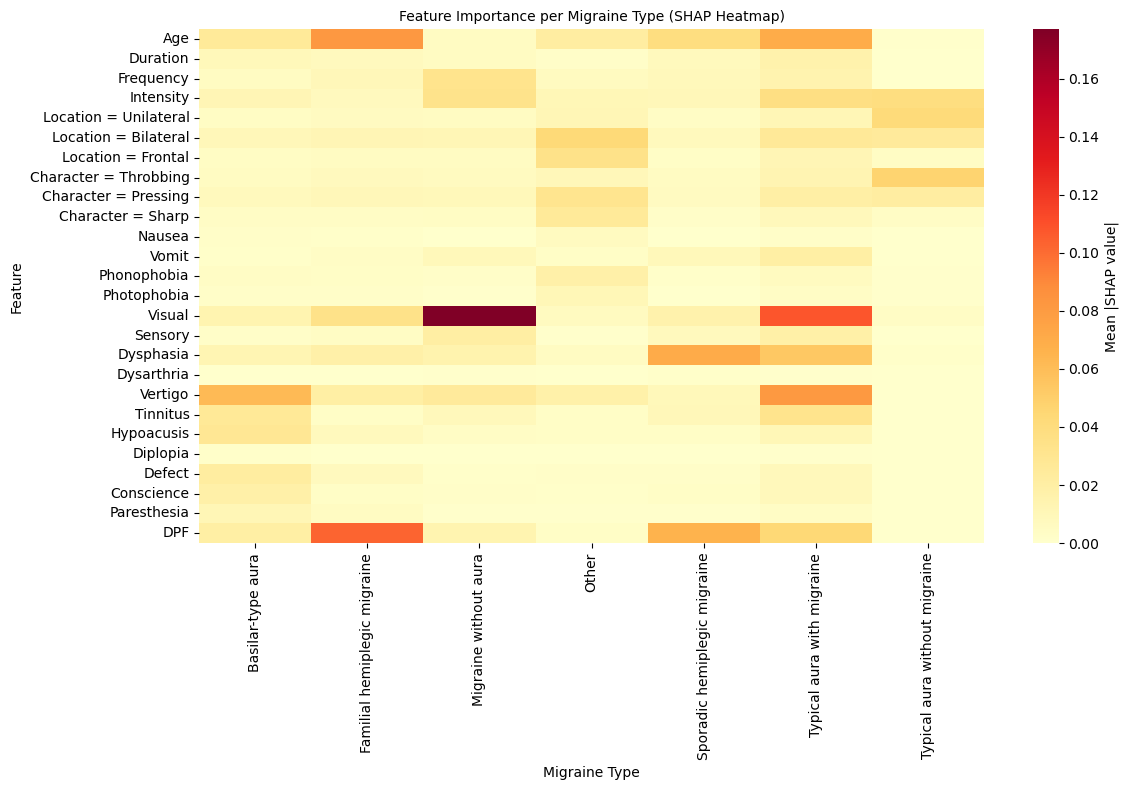

In [54]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_heatmap, cmap="YlOrRd", annot=False, cbar_kws={'label': 'Mean |SHAP value|'})
plt.title("Feature Importance per Migraine Type (SHAP Heatmap)")
plt.xlabel("Migraine Type")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


### Top 5 features per class (heatmap)

In [55]:

# Get feature names
feature_names = best_rf.named_steps['preprocessing'].get_feature_names_out()

# Mean absolute SHAP values across samples → shape (26, 7)
mean_shap_per_class = np.mean(np.abs(shap_values_test), axis=0)

# Put into DataFrame
df_shap = pd.DataFrame(mean_shap_per_class, 
                       index=friendly_names, 
                       columns=rf_model.classes_)


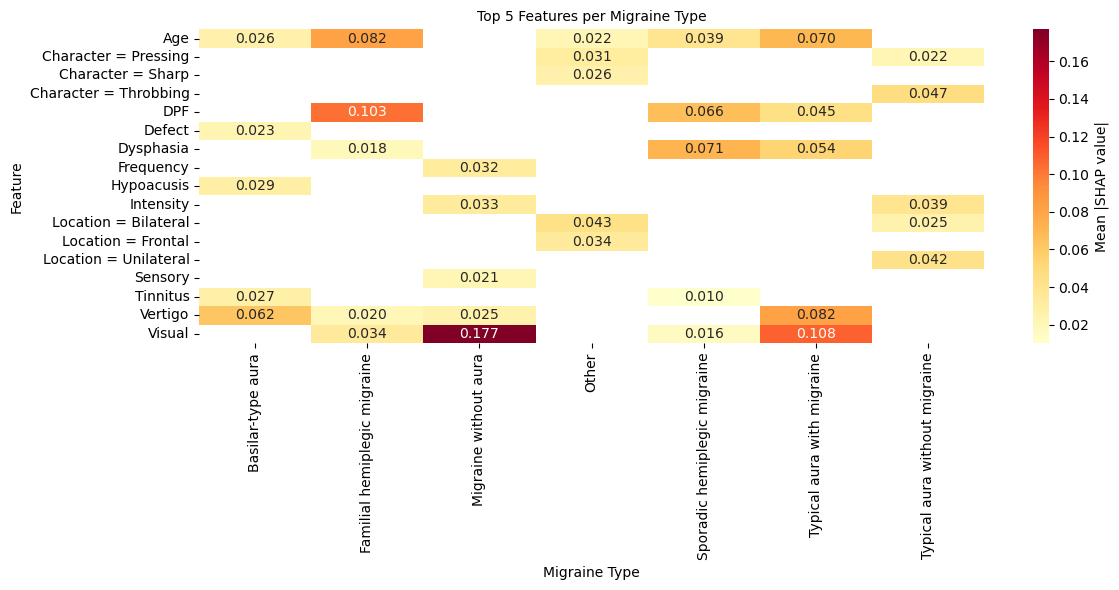

In [56]:
def top_features_per_class(df, top_n=5):
    results = {}
    for cls in df.columns:
        results[cls] = df[cls].sort_values(ascending=False).head(top_n)
    return pd.DataFrame(results)

# Get top 5 features per migraine type
top5_per_class = top_features_per_class(df_shap, top_n=5)
top5_per_class


plt.figure(figsize=(12, 6))
sns.heatmap(top5_per_class, annot=True, fmt=".3f", cmap="YlOrRd", cbar_kws={'label': 'Mean |SHAP value|'})
plt.title("Top 5 Features per Migraine Type")
plt.xlabel("Migraine Type")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


## 💾 Save the Best Model

To make the trained pipeline reusable for deployment or further analysis, we persist the **best Random Forest pipeline** (including preprocessing) using `joblib`.  
This ensures that all preprocessing steps (scaling, encoding, etc.) are saved together with the model.


In [57]:
# Save the full pipeline (preprocessing + model)
joblib.dump(best_rf, "best_rf.pkl")

# (Optional) Save label encoder if needed for XGBoost or other models
joblib.dump(label_encoder, "label_encoder.pkl")

print("✅ Best Random Forest pipeline and label encoder saved successfully.")



✅ Best Random Forest pipeline and label encoder saved successfully.



## 📘 Conclusion & Key Takeaways

This notebook demonstrated a complete workflow for **migraine subtype classification** using machine learning:

- 🧠 Compared three classifiers (Logistic Regression, Random Forest, XGBoost)  
- 🔍 Tuned hyperparameters and validated with 5‑fold cross‑validation  
- 📊 Random Forest achieved the best performance (Accuracy ≈ 95%, F1 ≈ 95%)  
- ⚖️ Addressed class imbalance with SMOTE inside pipelines  
- 💬 Enhanced interpretability with Random Forest feature importances and SHAP explanations  
- 💾 Serialized the best model pipeline for reuse and deployment  

**Key insight:** Visual and vestibular symptoms (e.g., visual aura, vertigo) consistently emerged as the strongest predictors across migraine types.  
